In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from torch import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
gamma = 0.9  # Discount factor 0.9
seed = 13

N = 50# #number of trajectories
L = 50# #length of traj.
K = 40
reg_normalizer=1

num_iters = 1500 # for attaining argmin
stepsize = 0.011 # Adam

num_states = 10
num_actions = 4

ssd_tol, ssd_max_iters = 1e-15 , 10000 # For steady state distribution calculation


mean_p = 0 # for random transition kernel obtained from normal distribution by normalization
variance_p = 1 
action_contrast = 1 #(softmax argument coefficient, lower this, lower the contrast)


torch.set_printoptions(precision=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

s0 = 0 # for test
s1 = 1
s2 = 2
V = torch.rand(num_states).to(device)

print(f'fixed state {s0}')
print(f'fixed state {s1}')
print(f'fixed state {s2}')

Using device: cuda
fixed state 0
fixed state 1
fixed state 2


In [3]:
class ProbabilisticEnvironment:
    def __init__(self):
        # Cost function for each state-action pair
        self.cost = torch.rand((num_states, num_actions), dtype=torch.float64, device=device)
        # Transition karnel: P(s' | s, a)
        self.cost[num_states-1]=torch.zeros_like(self.cost[num_states-1])
        
        self.transitions = torch.normal(mean_p, variance_p, size=(num_states, num_actions, num_states), dtype=torch.float64, device=device)
        self.transitions = F.softmax(action_contrast * self.transitions, dim=-1) # Softmax for normalization

    def next_state(self, state, action):
        # Sample the next state based on the transition probabilities for (state, action)
        next_state_probabilities = self.transitions[state, action] 
        next_state = torch.multinomial(next_state_probabilities, 1).item()
        return next_state

# Environment
env = ProbabilisticEnvironment()

In [4]:
def sample_trajectories(env, pi_k, s, a, N, L): # Function to sample trajectories using the policy Pi_k
    trajectories = []
    for __ in range(N):
        trajectory = [(s, a, env.cost[s, a].item())]  

        state = env.next_state(s, a)
        for _ in range(L-1):
            action_probs = pi_k[state].to(device)# Sample action based on current policy Pi_k(state, .)
            action = torch.multinomial(action_probs, 1).item()

            next_state = env.next_state(state, action)
            cost = env.cost[state, action].item()
            trajectory.append((state, action, cost))
            state = next_state
        trajectories.append(trajectory)
    return trajectories
    
def estimate_q_function(pi_k, tau, p, gamma, lp_coef): #based on trajectory
    Q = torch.zeros(num_states, num_actions, dtype=torch.float64, device=device)
    for s in range(num_states):
        for a in range(num_actions):
            trajectories = sample_trajectories(env, pi_k, s, a, N, L)
            for trajectory in trajectories:
                for t, (state, action, cost) in enumerate(trajectory):
                    Q[s, a] += (cost + reg_normalizer*REG_SC(pi_k[s], pi_0[s], tau, p, lp_coef))* (gamma ** t)
    Q /= N  
    return Q.to(device)

def estimate_q_function_real(pi_k, tau, gamma):#deterministic based on MPD dinamics
    # Build the one-step transition and cost matrices
    P_pi = torch.zeros(num_states, num_states, dtype=torch.float64, device=device)
    c_pi = torch.zeros(num_states, dtype=torch.float64, device=device)
    
    for s in range(num_states):
        for a in range(num_actions):
            P_sa = env.transitions[s, a]  
            P_pi[s] += pi_k[s, a] * P_sa
            c_pi[s] += pi_k[s, a] * (env.cost[s, a])
            
    # Solve (I - gamma * P_pi) * V = c_pi for V
    I = torch.eye(num_states, dtype=torch.float64, device=device)
    V = torch.linalg.solve(I - gamma * P_pi, c_pi)
    
    # Compute Q-function
    Q = torch.zeros(num_states, num_actions, dtype=torch.float64, device=device)
    for s in range(num_states):
        for a in range(num_actions):
            Q[s, a] = env.cost[s, a] + gamma * torch.dot(env.transitions[s, a], V)
    
    return Q

def steady_state_distribution(transition_kernel, policy, num_states, ssd_tol, ssd_max_iters):
    
    # Initialize the policy-dependent transition matrix T_pi (num_states, num_states)
    T_pi = torch.zeros(num_states, num_states, dtype=torch.float64, device=device)

    # Construct the policy-dependent transition matrix T_pi
    for s in range(num_states):
        for a in range(policy.shape[1]):  # num_actions
            T_pi[s] += policy[s, a] * transition_kernel[s, a]

    # Initialize the steady-state distribution (uniform initialization)
    rho = torch.ones(num_states, dtype=torch.float64, device=device) / num_states

    # Iterate to find the steady-state distribution (power iteration method)
    for _ in range(ssd_max_iters):  # Fixed typo here
        rho_next = torch.matmul(rho, T_pi)
        if torch.norm(rho_next - rho, p=1) < ssd_tol:
            break
        rho = rho_next

    # Normalize the steady-state distribution
    steady_state_dist = rho / rho.sum()

    return steady_state_dist
    
def kl_divergence(p, q):
    p = p.to(device)
    q = q.to(device)
    return torch.sum(p * (torch.log((p + 1e-305)/(q + 1e-305)))).to(device) 


def REG_SC(pi, pi_0, modulus, p, lp_coef):  # General function comprising all regularizers, selected by argument p
    pi = pi.to(device)
    entropy = kl_divergence(pi, pi_0)
    if p == 1:
        lp_term = torch.norm(pi-pi_0, p)
    else:
        lp_term = torch.norm(pi, p)
    # Return the regularization term
    return modulus * entropy + lp_coef*lp_term


def expected_entropy(pi_k, ssd):
    expected_entropy=0
    for s in range(num_states):
        expected_entropy += -torch.sum(pi_k[s] * torch.log(pi_k[s]+1e-306))*ssd[s]
    return expected_entropy


def obj(state_number,Q_pi_k, pi_k_s, pi_k, pi_0, eta, tau, p_norm, lp_coef): 
    value = (
                eta*(torch.dot(Q_pi_k[state_number], pi_k_s)
                + REG_SC(pi_k_s, pi_0[state_number], tau, p_norm, lp_coef))
                + kl_divergence(pi_k_s, pi_k[state_number])
             )
    return value


def optimize_pi_k_s(state_number, pi_k, Q_pi_k, pi_0, eta, tau, p_norm, num_iters, stepsize, lp_coef):

    logits_init = torch.log(pi_0[0])
    theta_k_s = logits_init.clone().detach().requires_grad_(True).to(device)

    optimizer = optim.Adam([theta_k_s], lr=stepsize)

    for t in range(num_iters):
        optimizer.zero_grad()

        pi_k_s = torch.softmax(theta_k_s, dim=0)

        loss = obj(state_number, Q_pi_k, pi_k_s, pi_k, pi_0, eta, tau, p_norm, lp_coef).to(device)

        loss.backward()
        optimizer.step()

    pi_k_s = torch.softmax(theta_k_s, dim=0).detach()

    return pi_k_s

def mismatch(p):
    diff = steady_state_distribution(env.transitions, optimal_policy, num_states, ssd_tol, ssd_max_iters) / steady_state_distribution(env.transitions, p, num_states, ssd_tol, ssd_max_iters)
    mis= torch.max(diff).item()
    return mis

In [5]:
pi_0 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
iter = 1000
################################################ Policy iteration ################################################
max_iterations = 1000
tolerance = 1e-100
policy = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions

for iteration in range(max_iterations):
    # Policy Evaluation
    # Compute c_π(s)
    c_pi = torch.sum(policy * env.cost, dim=1)  # size (num_states)
    
    # Compute P_π(s' | s)
    # P_π is of size (num_states, num_states)
    # For each state s, P_π[s] = ∑_{a} π(s, a) P(s' | s, a)
    P_pi = torch.einsum('sa,san->sn', policy, env.transitions)  # size (num_states, num_states)
    
    # Solve (I - γ P_π) V = c_π
    # Compute (I - γ P_π)
    I = torch.eye(num_states, dtype=torch.float64, device=device)
    A = I - gamma * P_pi  # size (num_states, num_states)
    
    # Solve for V
    V_new = torch.linalg.solve(A, c_pi)
    # Policy Improvement
    # For each state s, compute Q(s, a)
    # Q(s, a) = c(s, a) + γ ∑_{s'} P(s' | s, a) V(s')
    Q = env.cost + gamma * torch.einsum('san,n->sa', env.transitions, V_new)
    # Q is of size (num_states, num_actions)
    
    # For each state s, find actions that minimize Q(s, a)
    min_Q, _ = torch.min(Q, dim=1, keepdim=True)  # size (num_states, 1)
    optimal_actions = (Q == min_Q)  # size (num_states, num_actions)
    
    # Update policy
    policy_new = optimal_actions.double()
    # Normalize to get probabilities
    policy_new = policy_new / torch.sum(policy_new, dim=1, keepdim=True)
    
    # Check for convergence
    policy_change = torch.max(torch.abs(policy_new - policy))
    value_change = torch.max(torch.abs(V_new - V))
    print(f'Iteration {iteration}: Policy change {policy_change.item()}, Value change {value_change.item()}')
    if policy_change < tolerance:
        print(f'Policy converged at iteration {iteration}')
        break
    
    # Update policy and V
    policy = policy_new
    V = V_new
else:
    print('Policy iteration did not converge within the maximum number of iterations')

# Output optimal policy and value function
optimal_policy = policy
optimal_value = V

# Print optimal policy and value function
print('Optimal Policy:')
print(optimal_policy)
print('Optimal Value Function:')
print(optimal_value)
opt_policy_ssd = steady_state_distribution(env.transitions, optimal_policy, num_states, ssd_tol, ssd_max_iters)
print("opt_policy_ssd",opt_policy_ssd)

Iteration 0: Policy change 0.75, Value change 4.56469978685885
Iteration 1: Policy change 0.0, Value change 2.934719309519199
Policy converged at iteration 1
Optimal Policy:
tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
Optimal Value Function:
tensor([4.2727420292588620, 4.5429296580023601, 4.8853088646184633,
        4.4632542968818862, 4.5800028025677735, 4.6820310266665421,
        4.4501656743893747, 4.4048371720833099, 4.3120192047724606,
        3.9969409167068557], device='cuda:0', dtype=torch.float64)
opt_policy_ssd tensor([0.1133290330460370, 0.0943290594028035, 0.0768831518364066,
        0.1089923823446792, 0.1078594084456420, 0.0875921737406311,
        0.0968985111298333, 0.1110198673692344, 0.1279550018073490,
        0.075

In [6]:
pi_0 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_01 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k1 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_02 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k2 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_03 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k3 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_k_plus = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus1 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus2 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus3 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions

values=[]
values1=[]
values2=[]
values3=[]

KLterm=[]
KLterm1=[]
KLterm2=[]
KLterm3=[]

exp_entropy=[]
exp_entropy1=[]
exp_entropy2=[]
exp_entropy3=[]

diff=[]
diff1=[]
diff2=[]
diff3=[]
diff.append(mismatch(pi_0))
diff1.append(mismatch(pi_0))
diff2.append(mismatch(pi_0))
diff3.append(mismatch(pi_0))

record_value_stoch=[]
record_value_stoch1=[]
record_value_stoch2=[]
record_value_stoch3=[]

record_kl_stoch=[]
record_kl_stoch1=[]
record_kl_stoch2=[]
record_kl_stoch3=[]

record_entr_stoch=[]
record_entr_stoch1=[]
record_entr_stoch2=[]
record_entr_stoch3=[]

record_mism_stoch=[]
record_mism_stoch1=[]
record_mism_stoch2=[]
record_mism_stoch3=[]


record_q_stoch=[]
record_q1_stoch=[]
record_q2_stoch=[]
record_q3_stoch=[]

record_p_stoch=[]
record_p1_stoch=[]
record_p2_stoch=[]
record_p3_stoch=[]



estim_value = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd = torch.zeros(K, dtype=torch.float64, device=device)

estim_value1 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd1 = torch.zeros(K, dtype=torch.float64, device=device)

estim_value2 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd2 = torch.zeros(K, dtype=torch.float64, device=device)

estim_value3 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd3 = torch.zeros(K, dtype=torch.float64, device=device)

optimal_value = torch.zeros(num_states, dtype=torch.float64, device=device)

p_norm = 0
tau = 0
lp_coef=0
q_optimal_policy = estimate_q_function_real(optimal_policy, tau, gamma)
for j in range(num_states):
    optimal_value[j] = torch.dot(optimal_policy[j], q_optimal_policy[j])
opt_ssd = torch.dot(optimal_value, opt_policy_ssd).item()


print("Optimal Policy (per state):")
print(optimal_policy[0])
print("Optimal Value Function (per state):")
print(optimal_value[0])

Optimal Policy (per state):
tensor([0., 0., 1., 0.], device='cuda:0', dtype=torch.float64)
Optimal Value Function (per state):
tensor(1.6133674526052586, device='cuda:0', dtype=torch.float64)


Pi_0(.|s0), 1st = tensor([0.2161431986746203, 0.2961029311570078, 0.2654926730731355,
        0.2222611970952364], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 2nd= tensor([0.2500698088803764, 0.2488933155660999, 0.2541125297676574,
        0.2469243457858663], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 3rd = tensor([0.2205354356859258, 0.2748792433730967, 0.3011141230620140,
        0.2034711978789634], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 4th= tensor([0.2358766501611739, 0.2409985521705045, 0.3137505548811160,
        0.2093742427872056], device='cuda:0', dtype=torch.float64)
under steady state distribution at iteration 0:
estm value, 1st: 4.3482087161601815 opt value: 1.653775138332813
estm value, 2nd: 4.404334866474023 opt value: 1.653775138332813
estm value, 3rd: 4.874032441501234 opt value: 1.653775138332813
estm value, 4th: 4.77279818111734 opt value: 1.653775138332813

E[KL(pi*(s) || pi_0(s))] ~ssd, 1st : 11.409722783156262
E[KL(pi*(s) || pi_0(s))] ~ssd

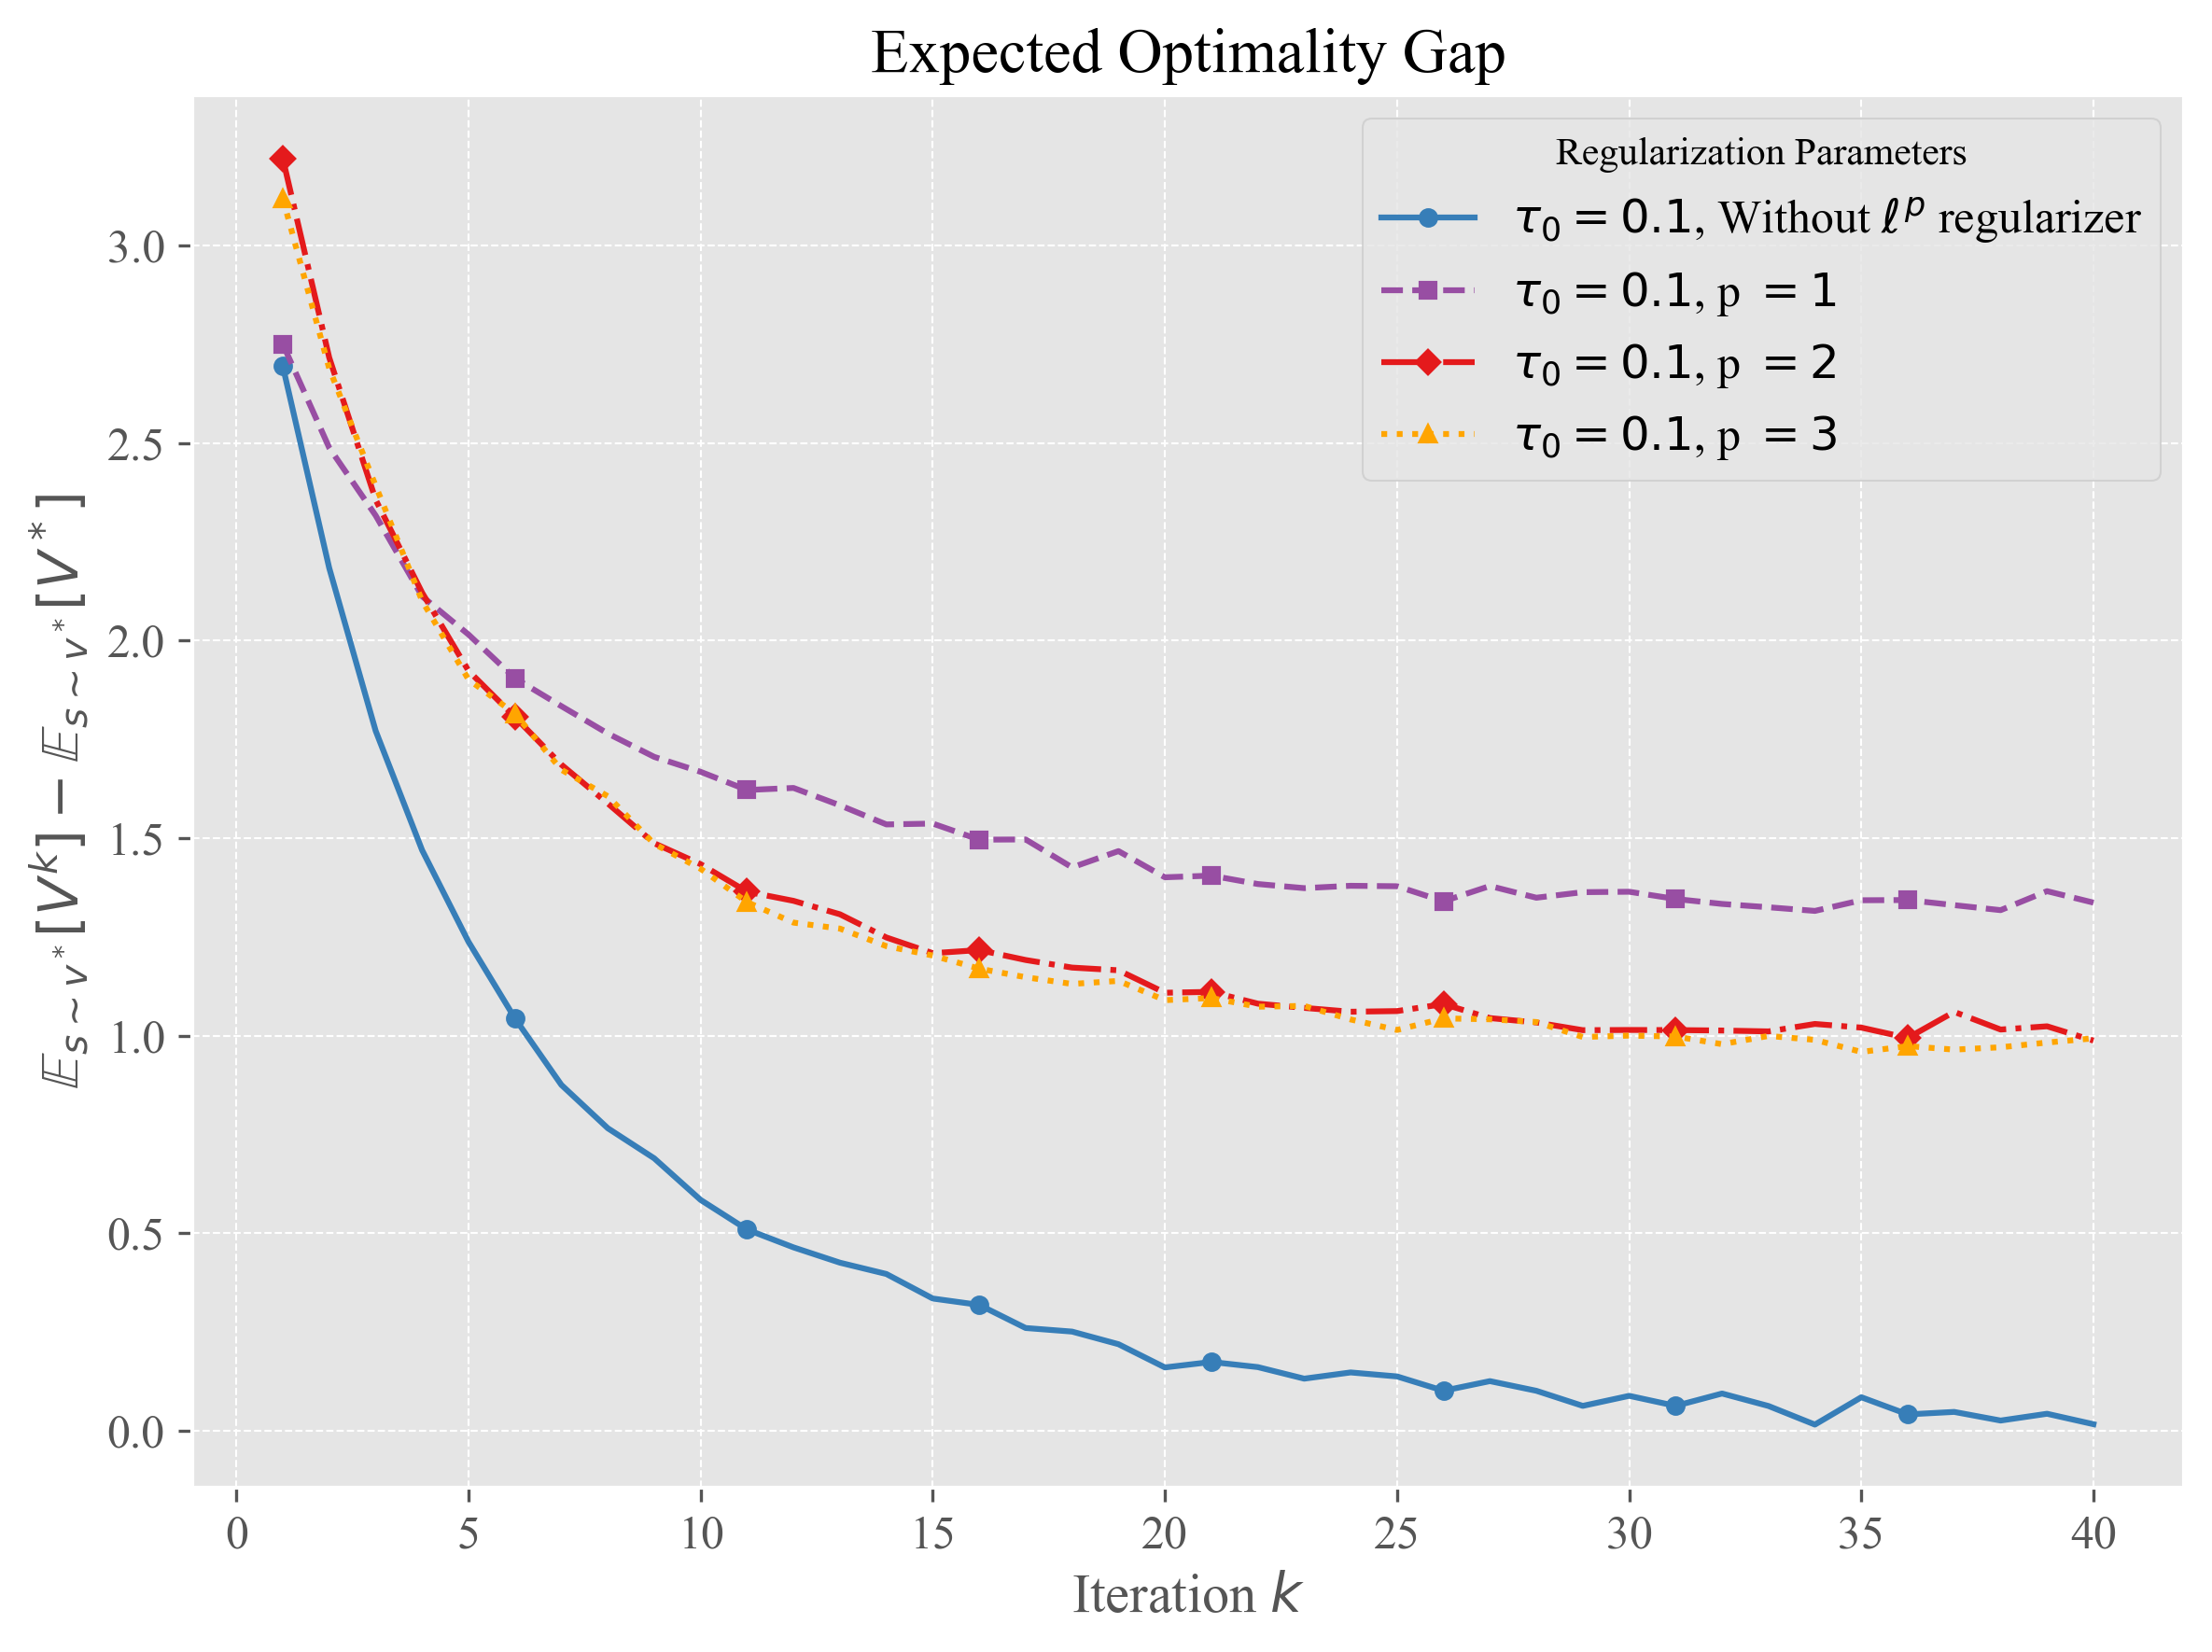

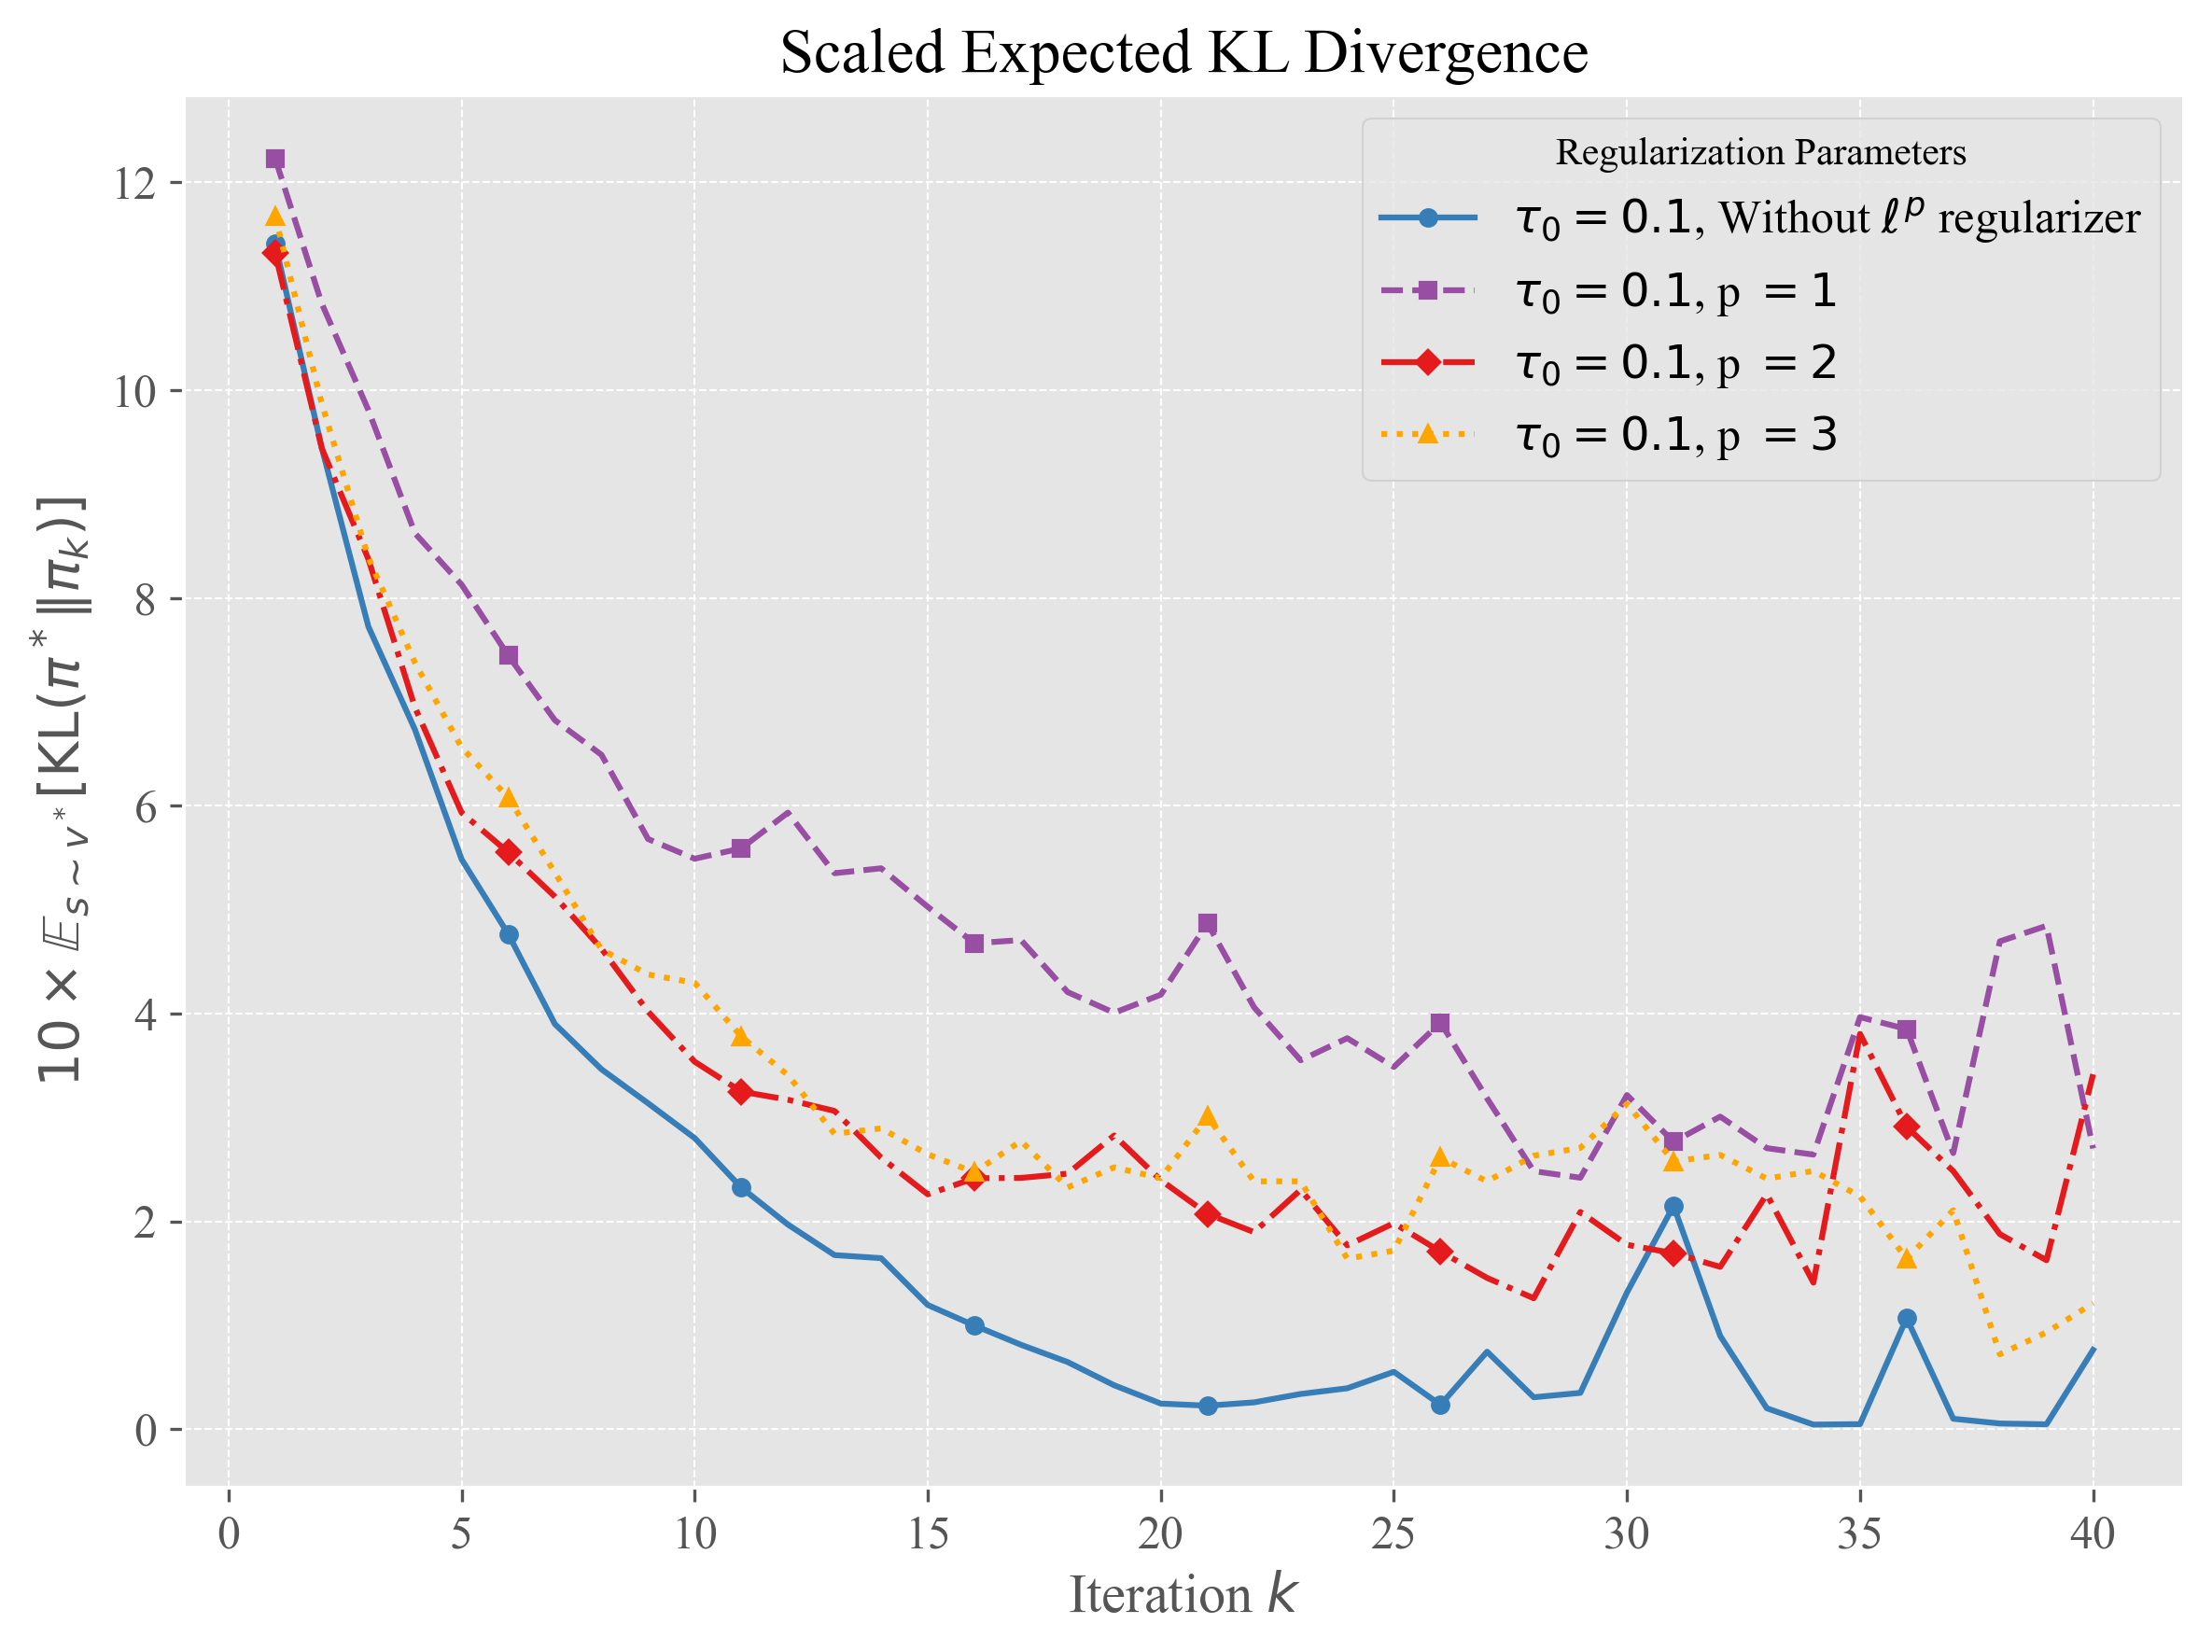

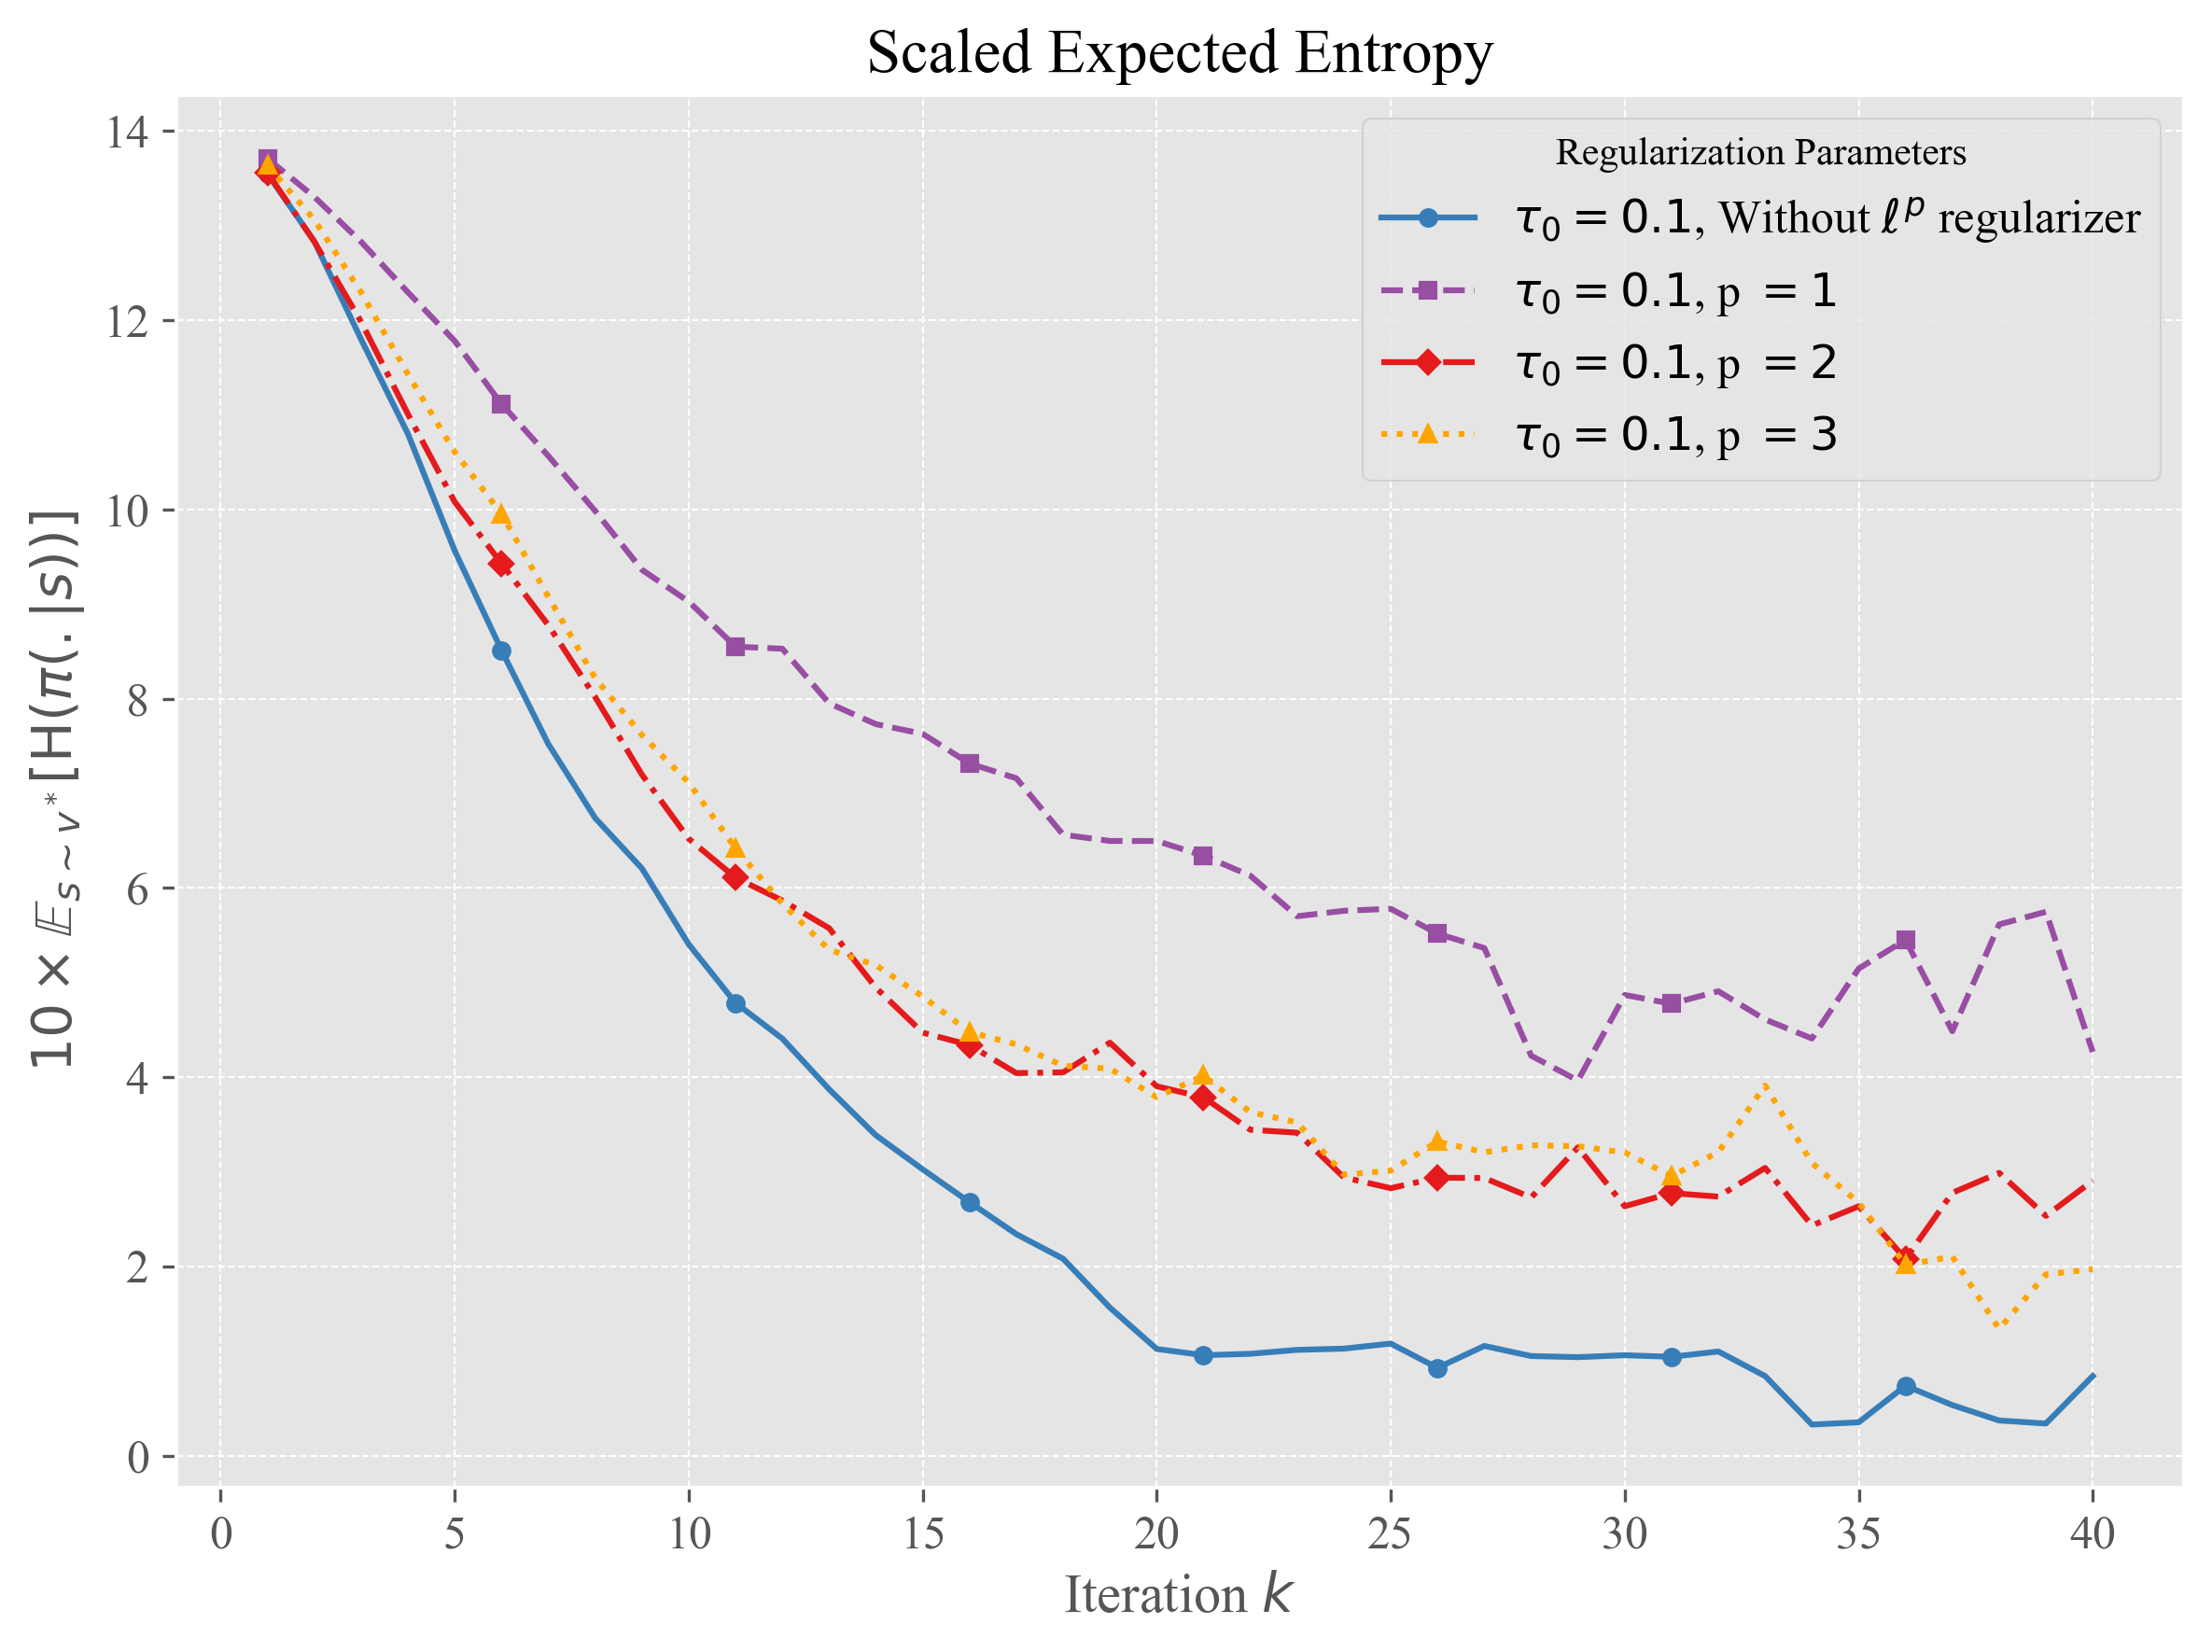

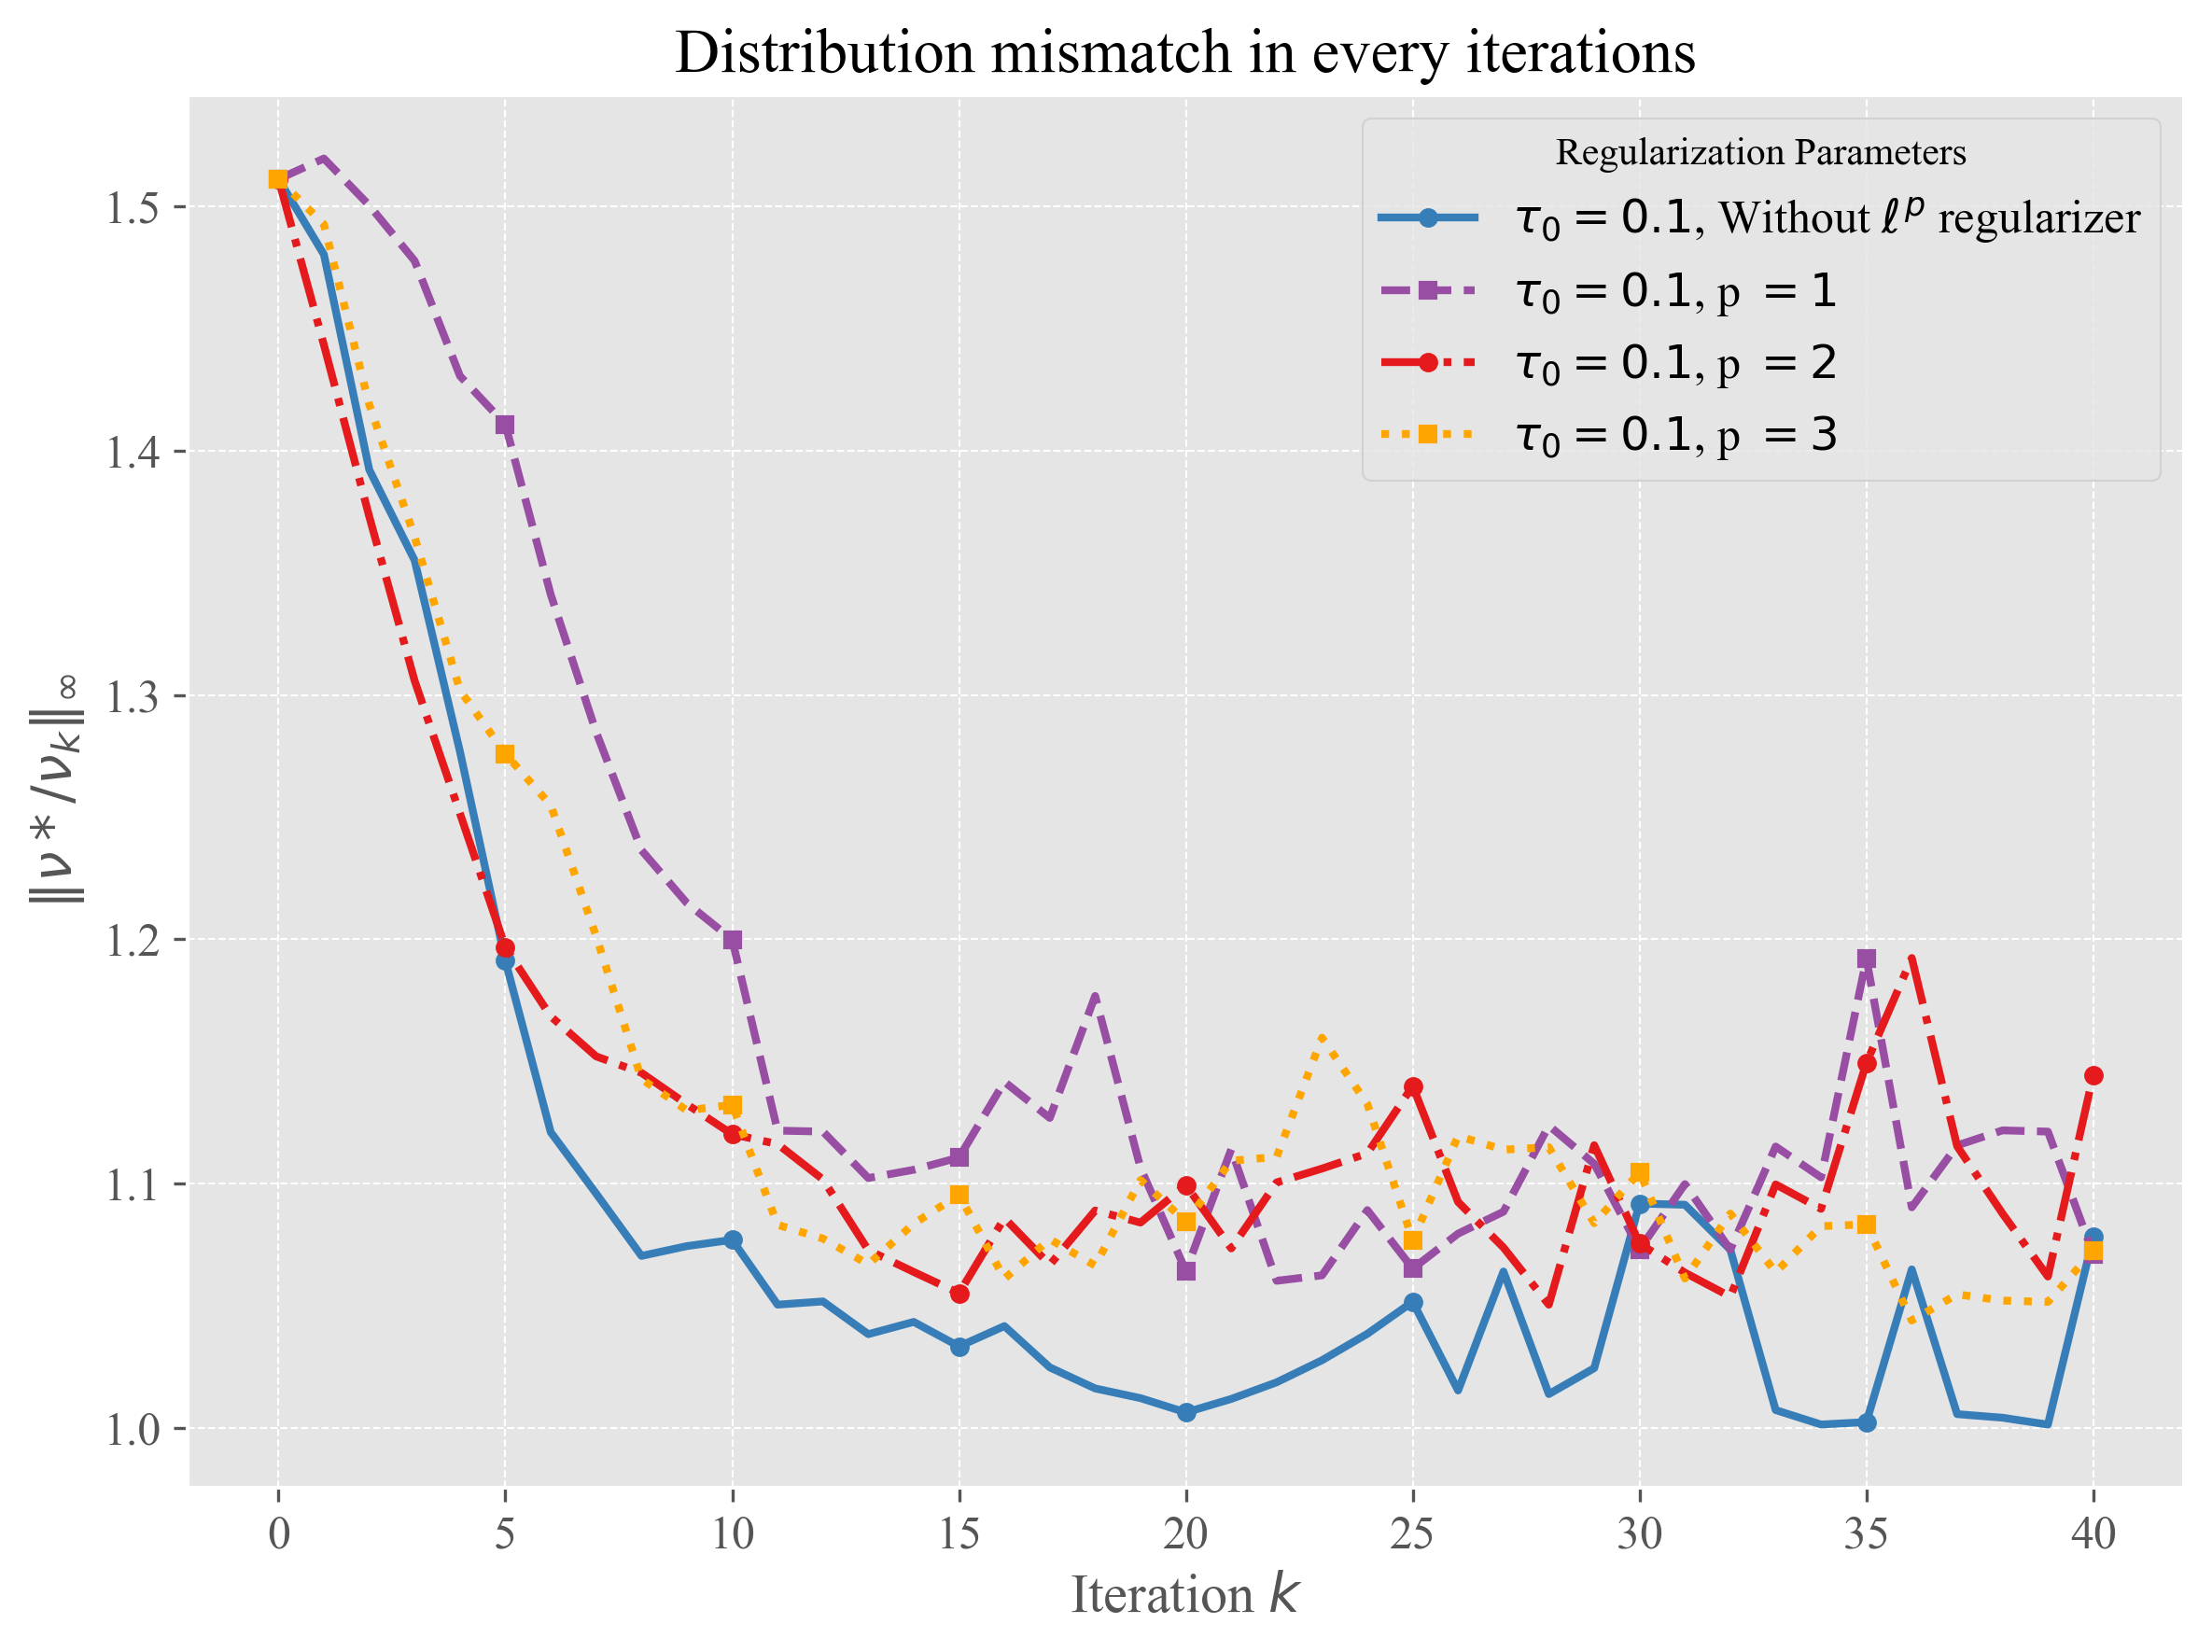

In [7]:
tau = 0.1 #initial value
tau1 = 0.1
tau2 = 0.1
tau3 = 0.1

tau0 = tau # to store the initializaion for figures
tau01 = tau1 # to store the initializaion
tau02 = tau2 # to store the initializaion
tau03 = tau3 # to store the initializaion

eta = (1-gamma)/(gamma*tau) #step size according to the step size assumption in Theorem 1
eta1 = (1-gamma)/(gamma*tau1)
eta2 = (1-gamma)/(gamma*tau2)
eta3 = (1-gamma)/(gamma*tau3)

modulus_lp = 0
modulus_lp_second = 1
modulus_lp_third = 2
modulus_lp_forth = 3

lp_coef=0 
lp_coef1=0.1
lp_coef2=0.1
lp_coef3=0.1


for k in range(K):
    Q_pi_k = estimate_q_function(pi_k, tau, modulus_lp, gamma, lp_coef).to(device)
    Q_pi_k1 = estimate_q_function(pi_k1, tau1, modulus_lp_second, gamma, lp_coef1).to(device)
    Q_pi_k2= estimate_q_function(pi_k2, tau2, modulus_lp_third, gamma, lp_coef2).to(device)
    Q_pi_k3 = estimate_q_function(pi_k3, tau3, modulus_lp_forth, gamma, lp_coef3).to(device)
    
    record_q_stoch.append(Q_pi_k)
    record_q1_stoch.append(Q_pi_k1)
    record_q2_stoch.append(Q_pi_k2)
    record_q3_stoch.append(Q_pi_k3)

    kl_term = 0
    kl_term1 = 0
    kl_term2 = 0
    kl_term3 = 0

    for i in range(num_states):
        pi_k_plus[i] = optimize_pi_k_s(i, pi_k, Q_pi_k, pi_0, eta, tau, modulus_lp, num_iters, stepsize, lp_coef)
        pi_k_plus1[i] = optimize_pi_k_s(i, pi_k1, Q_pi_k1, pi_0, eta1, tau1, modulus_lp_second, num_iters, stepsize, lp_coef1)
        pi_k_plus2[i] = optimize_pi_k_s(i, pi_k2, Q_pi_k2, pi_0, eta2, tau2, modulus_lp_third, num_iters, stepsize, lp_coef2)
        pi_k_plus3[i] = optimize_pi_k_s(i, pi_k3, Q_pi_k3, pi_0, eta3, tau3, modulus_lp_forth, num_iters, stepsize, lp_coef3)
        
        estim_value[i] = torch.dot(pi_k_plus[i], Q_pi_k[i]).item()
        estim_value1[i] = torch.dot(pi_k_plus1[i], Q_pi_k1[i]).item()
        estim_value2[i] = torch.dot(pi_k_plus2[i], Q_pi_k2[i]).item()
        estim_value3[i] = torch.dot(pi_k_plus3[i], Q_pi_k3[i]).item()
        
        kl_term += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus[i])
        kl_term1 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus1[i])   
        kl_term2 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus2[i])
        kl_term3 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus3[i])   
        
    estim_value_ssd[k] = torch.dot(estim_value, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd1[k] = torch.dot(estim_value1, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd2[k] = torch.dot(estim_value2, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd3[k] = torch.dot(estim_value3, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd

    exp_entropy.append(10*expected_entropy(pi_k_plus, opt_policy_ssd).item())
    exp_entropy1.append(10*expected_entropy(pi_k_plus1, opt_policy_ssd).item())
    exp_entropy2.append(10*expected_entropy(pi_k_plus2, opt_policy_ssd).item())
    exp_entropy3.append(10*expected_entropy(pi_k_plus3, opt_policy_ssd).item())

    
    pi_k = pi_k_plus
    pi_k1 = pi_k_plus1
    pi_k2 = pi_k_plus2
    pi_k3 = pi_k_plus3

    record_p_stoch.append(pi_k)
    record_p1_stoch.append(pi_k1)
    record_p2_stoch.append(pi_k2)
    record_p3_stoch.append(pi_k3)


    tau*=gamma
    eta = (1-gamma)/(gamma*tau)
    tau1*=gamma
    eta1 = (1-gamma)/(gamma*tau1)
    tau2*=gamma
    eta2 = (1-gamma)/(gamma*tau2)
    tau3*=gamma
    eta3 = (1-gamma)/(gamma*tau3)
    
    V_pi_k_s0 = torch.dot(pi_k[s0], Q_pi_k[s0]).item()
    V_pi_k_s01 = torch.dot(pi_k1[s0], Q_pi_k1[s0]).item()
    V_pi_k_s02 = torch.dot(pi_k2[s0], Q_pi_k2[s0]).item()
    V_pi_k_s03 = torch.dot(pi_k3[s0], Q_pi_k3[s0]).item()

    values.append(V_pi_k_s0)
    values1.append(V_pi_k_s01)
    values2.append(V_pi_k_s02)
    values3.append(V_pi_k_s03)
    
    KLterm.append((10*kl_term).item())
    KLterm1.append((10*kl_term1).item())
    KLterm2.append((10*kl_term2).item())
    KLterm3.append((10*kl_term3).item())

    diff.append(mismatch(pi_k))
    diff1.append(mismatch(pi_k1))
    diff2.append(mismatch(pi_k2))
    diff3.append(mismatch(pi_k3))
    
    print(f"Pi_{k}(.|s0), 1st = {pi_k[0]}")
    print(f"Pi_{k}(.|s0), 2nd= {pi_k1[0]}")
    print(f"Pi_{k}(.|s0), 3rd = {pi_k2[0]}")
    print(f"Pi_{k}(.|s0), 4th= {pi_k3[0]}")
    
    print(f'under steady state distribution at iteration {k}:')
    print('estm value, 1st:',estim_value_ssd[k].item(),'opt value:', opt_ssd)
    print('estm value, 2nd:',estim_value_ssd1[k].item(),'opt value:', opt_ssd)
    print('estm value, 3rd:',estim_value_ssd2[k].item(),'opt value:', opt_ssd)
    print('estm value, 4th:',estim_value_ssd3[k].item(),'opt value:', opt_ssd)
    print()
    
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 1st : {10*kl_term}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 2nd : {10*kl_term1}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 3rd : {10*kl_term2}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 4th : {10*kl_term3}')
    print()




expected_opt_gap = estim_value_ssd[0:K] - opt_ssd
expected_opt_gap1 = estim_value_ssd1[0:K] - opt_ssd
expected_opt_gap2 = estim_value_ssd2[0:K] - opt_ssd
expected_opt_gap3 = estim_value_ssd3[0:K] - opt_ssd


record_value_stoch.append(expected_opt_gap)
record_value_stoch1.append(expected_opt_gap1)
record_value_stoch2.append(expected_opt_gap2)
record_value_stoch3.append(expected_opt_gap3)

record_kl_stoch.append(KLterm)
record_kl_stoch1.append(KLterm1)
record_kl_stoch2.append(KLterm2)
record_kl_stoch3.append(KLterm3)

record_entr_stoch.append(exp_entropy)
record_entr_stoch1.append(exp_entropy1)
record_entr_stoch2.append(exp_entropy2)
record_entr_stoch3.append(exp_entropy3)

record_mism_stoch.append(diff)
record_mism_stoch1.append(diff1)
record_mism_stoch2.append(diff2)
record_mism_stoch3.append(diff3)


print('expected optimality gap after last iteration, 1st', expected_opt_gap[-1])
print('expected optimality gap after last iteration, 2nd', expected_opt_gap1[-1])
print('expected optimality gap after last iteration, 3rd', expected_opt_gap2[-1])
print('expected optimality gap after last iteration, 4th', expected_opt_gap3[-1])

plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), expected_opt_gap.tolist(), color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), expected_opt_gap1.tolist(), color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), expected_opt_gap2.tolist(), color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), expected_opt_gap3.tolist(), color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$\\mathbb{E}_{s \\sim v^*}[V^k] - \\mathbb{E}_{s \\sim v^*}[V^*]$', fontsize=14)
plt.title('Expected Optimality Gap', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_optimality_l00p.png', dpi=300)



plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), KLterm, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), KLterm1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), KLterm2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), KLterm3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{KL}(\\pi^* \\| \\pi_k)]$', fontsize=14)
plt.title('Scaled Expected KL Divergence', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_l00p.png', dpi=300)
plt.show()


plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), exp_entropy, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), exp_entropy1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), exp_entropy2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), exp_entropy3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{H}(\\pi(.|s))]$', fontsize=14)
plt.title('Scaled Expected Entropy', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_divergence_l00p.png', dpi=300)
plt.show()




plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'o', 's']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(0, K+1), diff, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(0, K+1), diff1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(0, K+1), diff2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(0, K+1), diff3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel(r'$\|\nu*/\nu_k\|_\infty$', fontsize=14)
plt.title('Distribution mismatch in every iterations', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_l00p.png', dpi=300)
plt.show()

diff0, diff01, diff02, diff03 = diff , diff1, diff2, diff3
exp_entropy0, exp_entropy01, exp_entropy02, exp_entropy03 = exp_entropy, exp_entropy1, exp_entropy2, exp_entropy3
KLterm0, KLterm01, KLterm02, KLterm03 = KLterm, KLterm1, KLterm2, KLterm3
expected_opt_gap0, expected_opt_gap01, expected_opt_gap02, expected_opt_gap03 = expected_opt_gap, expected_opt_gap1, expected_opt_gap2, expected_opt_gap3

In [ ]:
##############################################################################################################################################

In [ ]:
##### Exact case

In [8]:
def estimate_q_function_exact(pi_k, tau, p,gamma, lp_coef):
    P_pi = torch.zeros(num_states, num_states, dtype=torch.float64, device=device)
    c_pi = torch.zeros(num_states, dtype=torch.float64, device=device)
    for s in range(num_states):
        for a in range(num_actions):
            P_sa = env.transitions[s, a]  # Transition probabilities
            P_pi[s] += pi_k[s, a] * P_sa
            c_pi[s] += pi_k[s, a] * (env.cost[s, a] +  reg_normalizer*REG_SC(pi_k[s], pi_0[s], tau, p, lp_coef))
            
    # Solve (I - gamma * P_pi) * V = c_pi for V
    I = torch.eye(num_states, dtype=torch.float64, device=device)
    V = torch.linalg.solve(I - gamma * P_pi, c_pi)
    
    # Compute Q-function
    Q = torch.zeros(num_states, num_actions, dtype=torch.float64, device=device)
    for s in range(num_states):
        for a in range(num_actions):
            Q[s, a] = env.cost[s, a] +  reg_normalizer*REG_SC(pi_k[s], pi_0[s], tau, p, lp_coef) + gamma * torch.dot(env.transitions[s, a], V)
    
    return Q

In [9]:
pi_0 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_01 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k1 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_02 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k2 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_03 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'
pi_k3 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions # uniform dist.'

pi_k_plus = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus1 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus2 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions
pi_k_plus3 = torch.ones((num_states, num_actions), dtype=torch.float64, device=device) / num_actions

values=[]
values1=[]
values2=[]
values3=[]

KLterm=[]
KLterm1=[]
KLterm2=[]
KLterm3=[]

exp_entropy=[]
exp_entropy1=[]
exp_entropy2=[]
exp_entropy3=[]

diff=[]
diff1=[]
diff2=[]
diff3=[]
diff.append(mismatch(pi_0))
diff1.append(mismatch(pi_0))
diff2.append(mismatch(pi_0))
diff3.append(mismatch(pi_0))

record_value_exact=[]
record_value_exact1=[]
record_value_exact2=[]
record_value_exact3=[]

record_kl_exact=[]
record_kl_exact1=[]
record_kl_exact2=[]
record_kl_exact3=[]

record_entr_exact=[]
record_entr_exact1=[]
record_entr_exact2=[]
record_entr_exact3=[]

record_mism_exact=[]
record_mism_exact1=[]
record_mism_exact2=[]
record_mism_exact3=[]


record_q_exact=[]
record_q1_exact1=[]
record_q2_exact2=[]
record_q3_exact3=[]

record_p_exact=[]
record_p1_exact1=[]
record_p2_exact2=[]
record_p3_exact3=[]

estim_value = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd = torch.zeros(K, dtype=torch.float64, device=device)

estim_value1 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd1 = torch.zeros(K, dtype=torch.float64, device=device)

estim_value2 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd2 = torch.zeros(K, dtype=torch.float64, device=device)

estim_value3 = torch.zeros(num_states, dtype=torch.float64, device=device)
estim_value_ssd3 = torch.zeros(K, dtype=torch.float64, device=device)

optimal_value = torch.zeros(num_states, dtype=torch.float64, device=device)

Pi_0(.|s0), 1st = tensor([0.2267726020411527, 0.2612024168122553, 0.2829286623275519,
        0.2290963188190400], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 2nd= tensor([0.2479173733844519, 0.2502947303544111, 0.2532404782549868,
        0.2485474180061502], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 3rd = tensor([0.2278668461868725, 0.2607491338526490, 0.2812846051922150,
        0.2300994147682635], device='cuda:0', dtype=torch.float64)
Pi_0(.|s0), 4th= tensor([0.2284477989810133, 0.2605598519218437, 0.2803491317095357,
        0.2306432173876073], device='cuda:0', dtype=torch.float64)
under steady state distribution at iteration 0:
estm value, 1st: 4.39448458808023 opt value: 1.653775138332813
estm value, 2nd: 4.411175376028236 opt value: 1.653775138332813
estm value, 3rd: 4.89685220616526 opt value: 1.653775138332813
estm value, 4th: 4.794761109932027 opt value: 1.653775138332813

E[KL(pi*(s) || pi_0(s))] ~ssd, 1st : 11.356035845818033
E[KL(pi*(s) || pi_0(s))] ~ssd, 

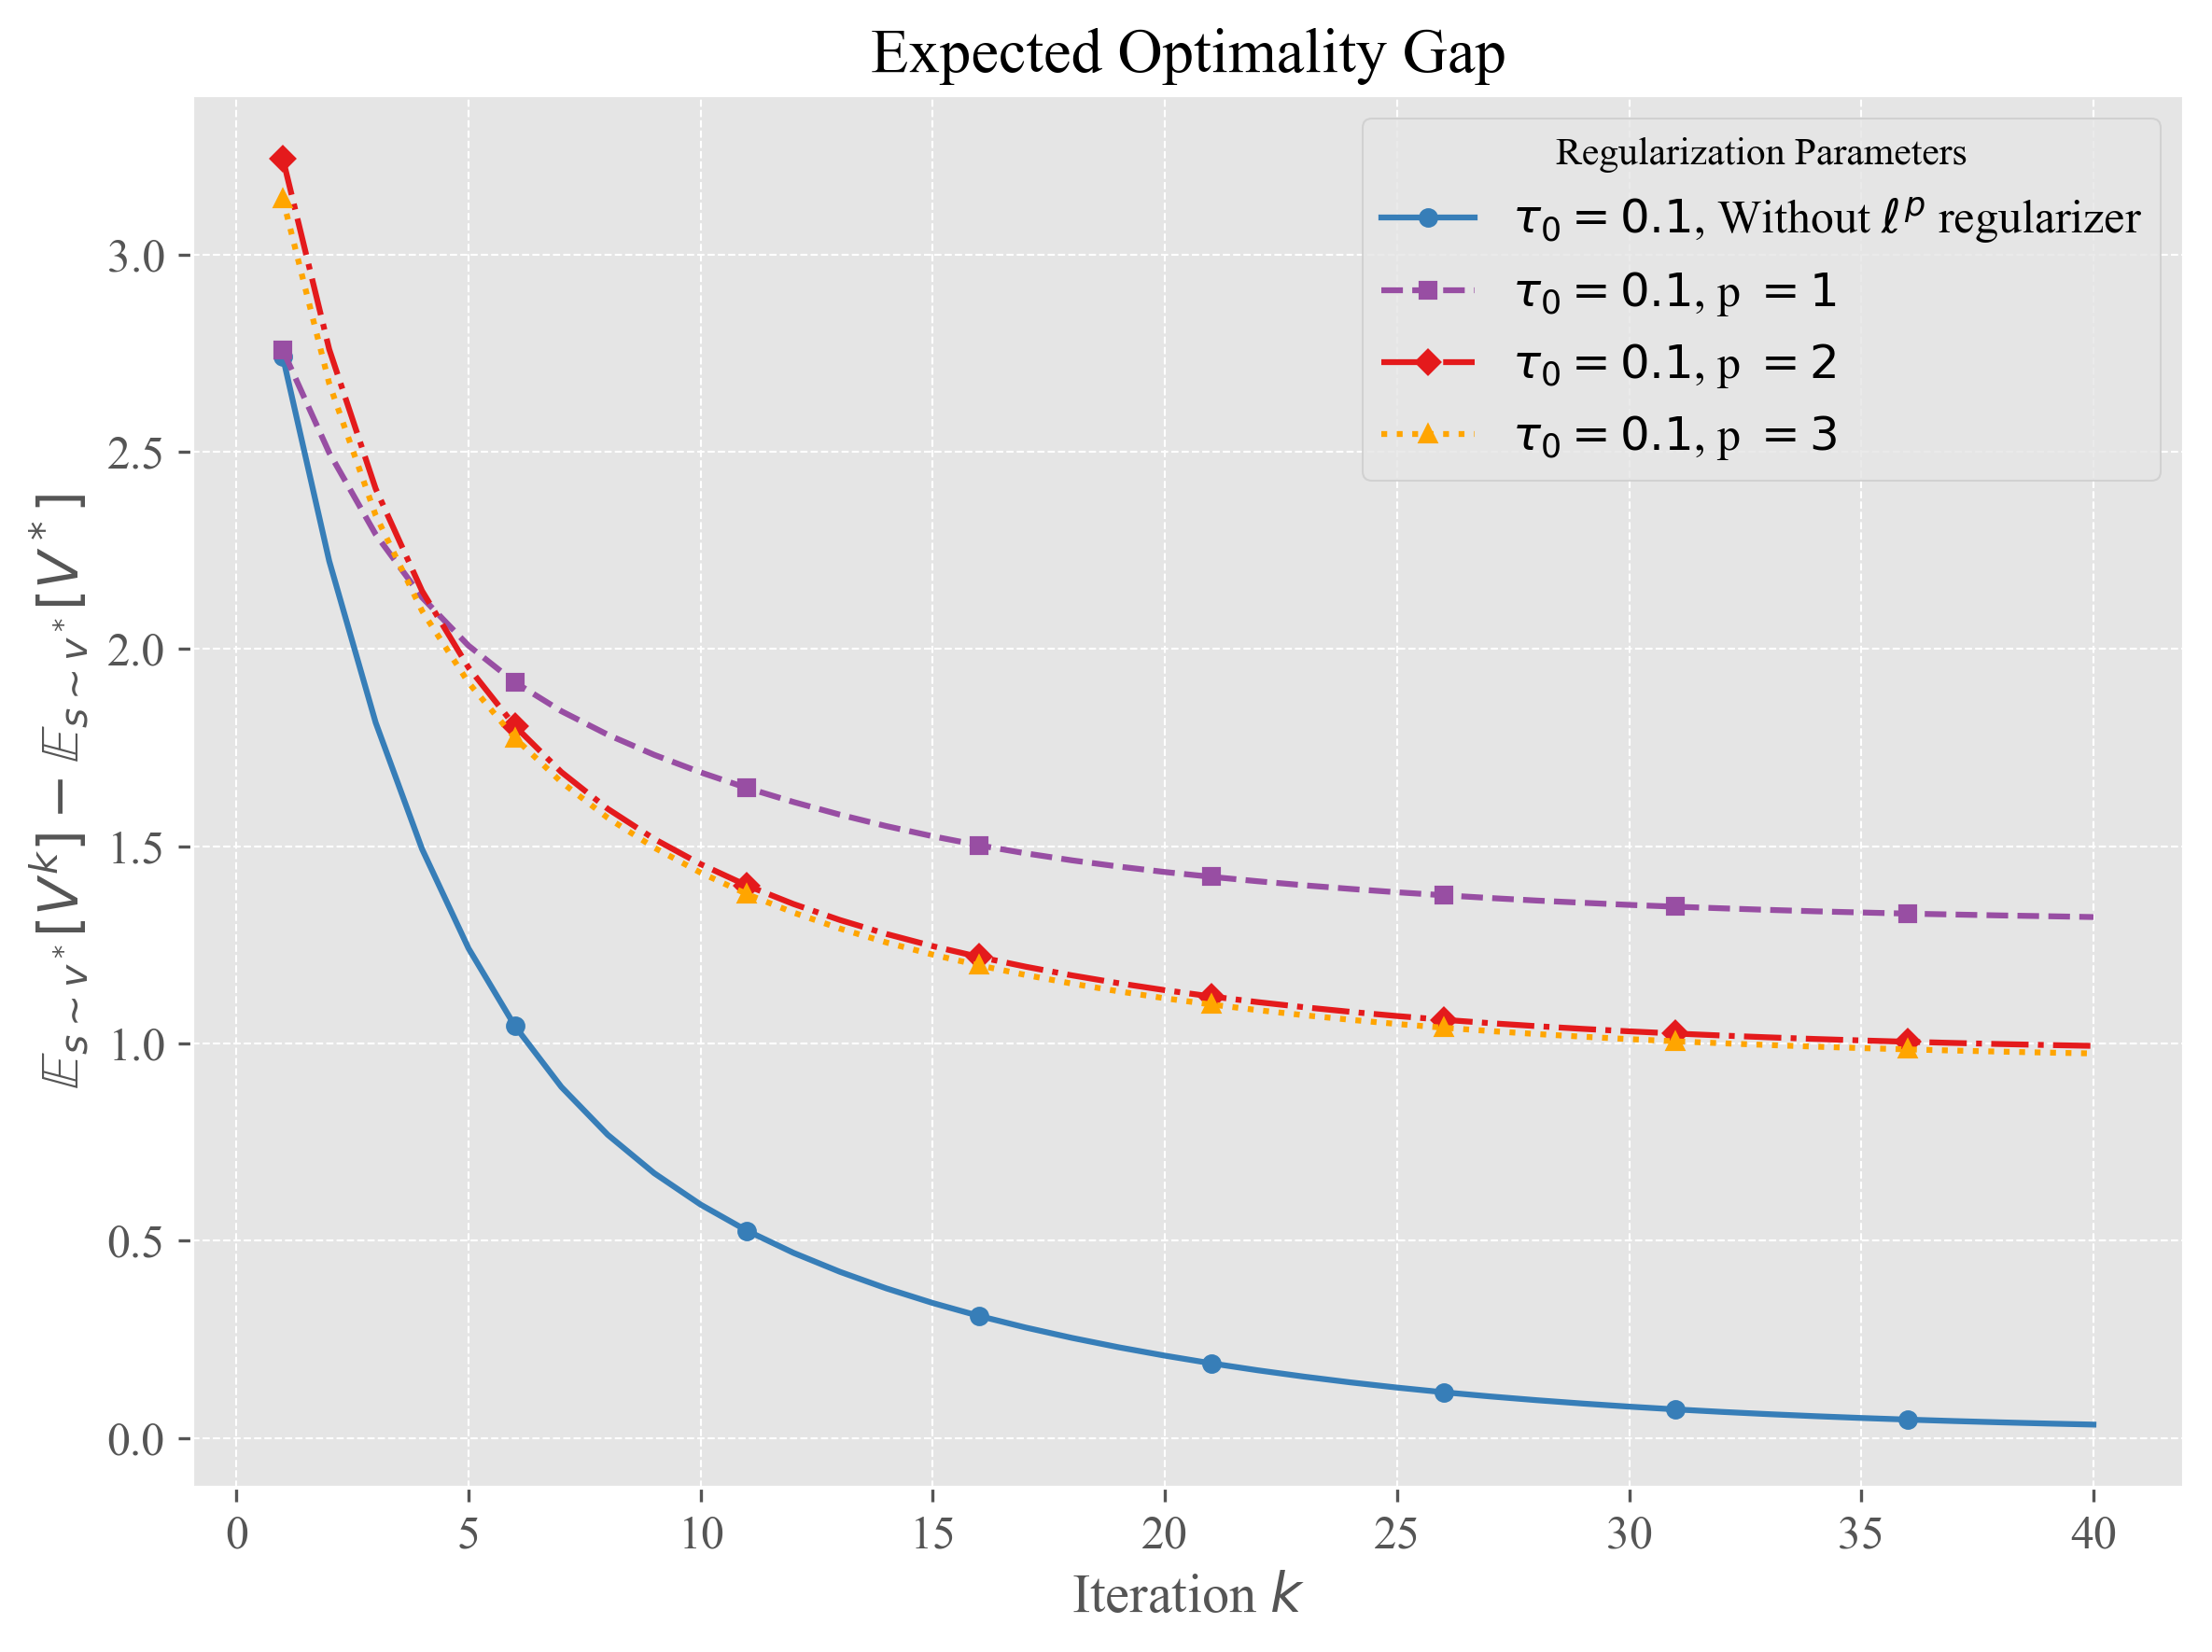

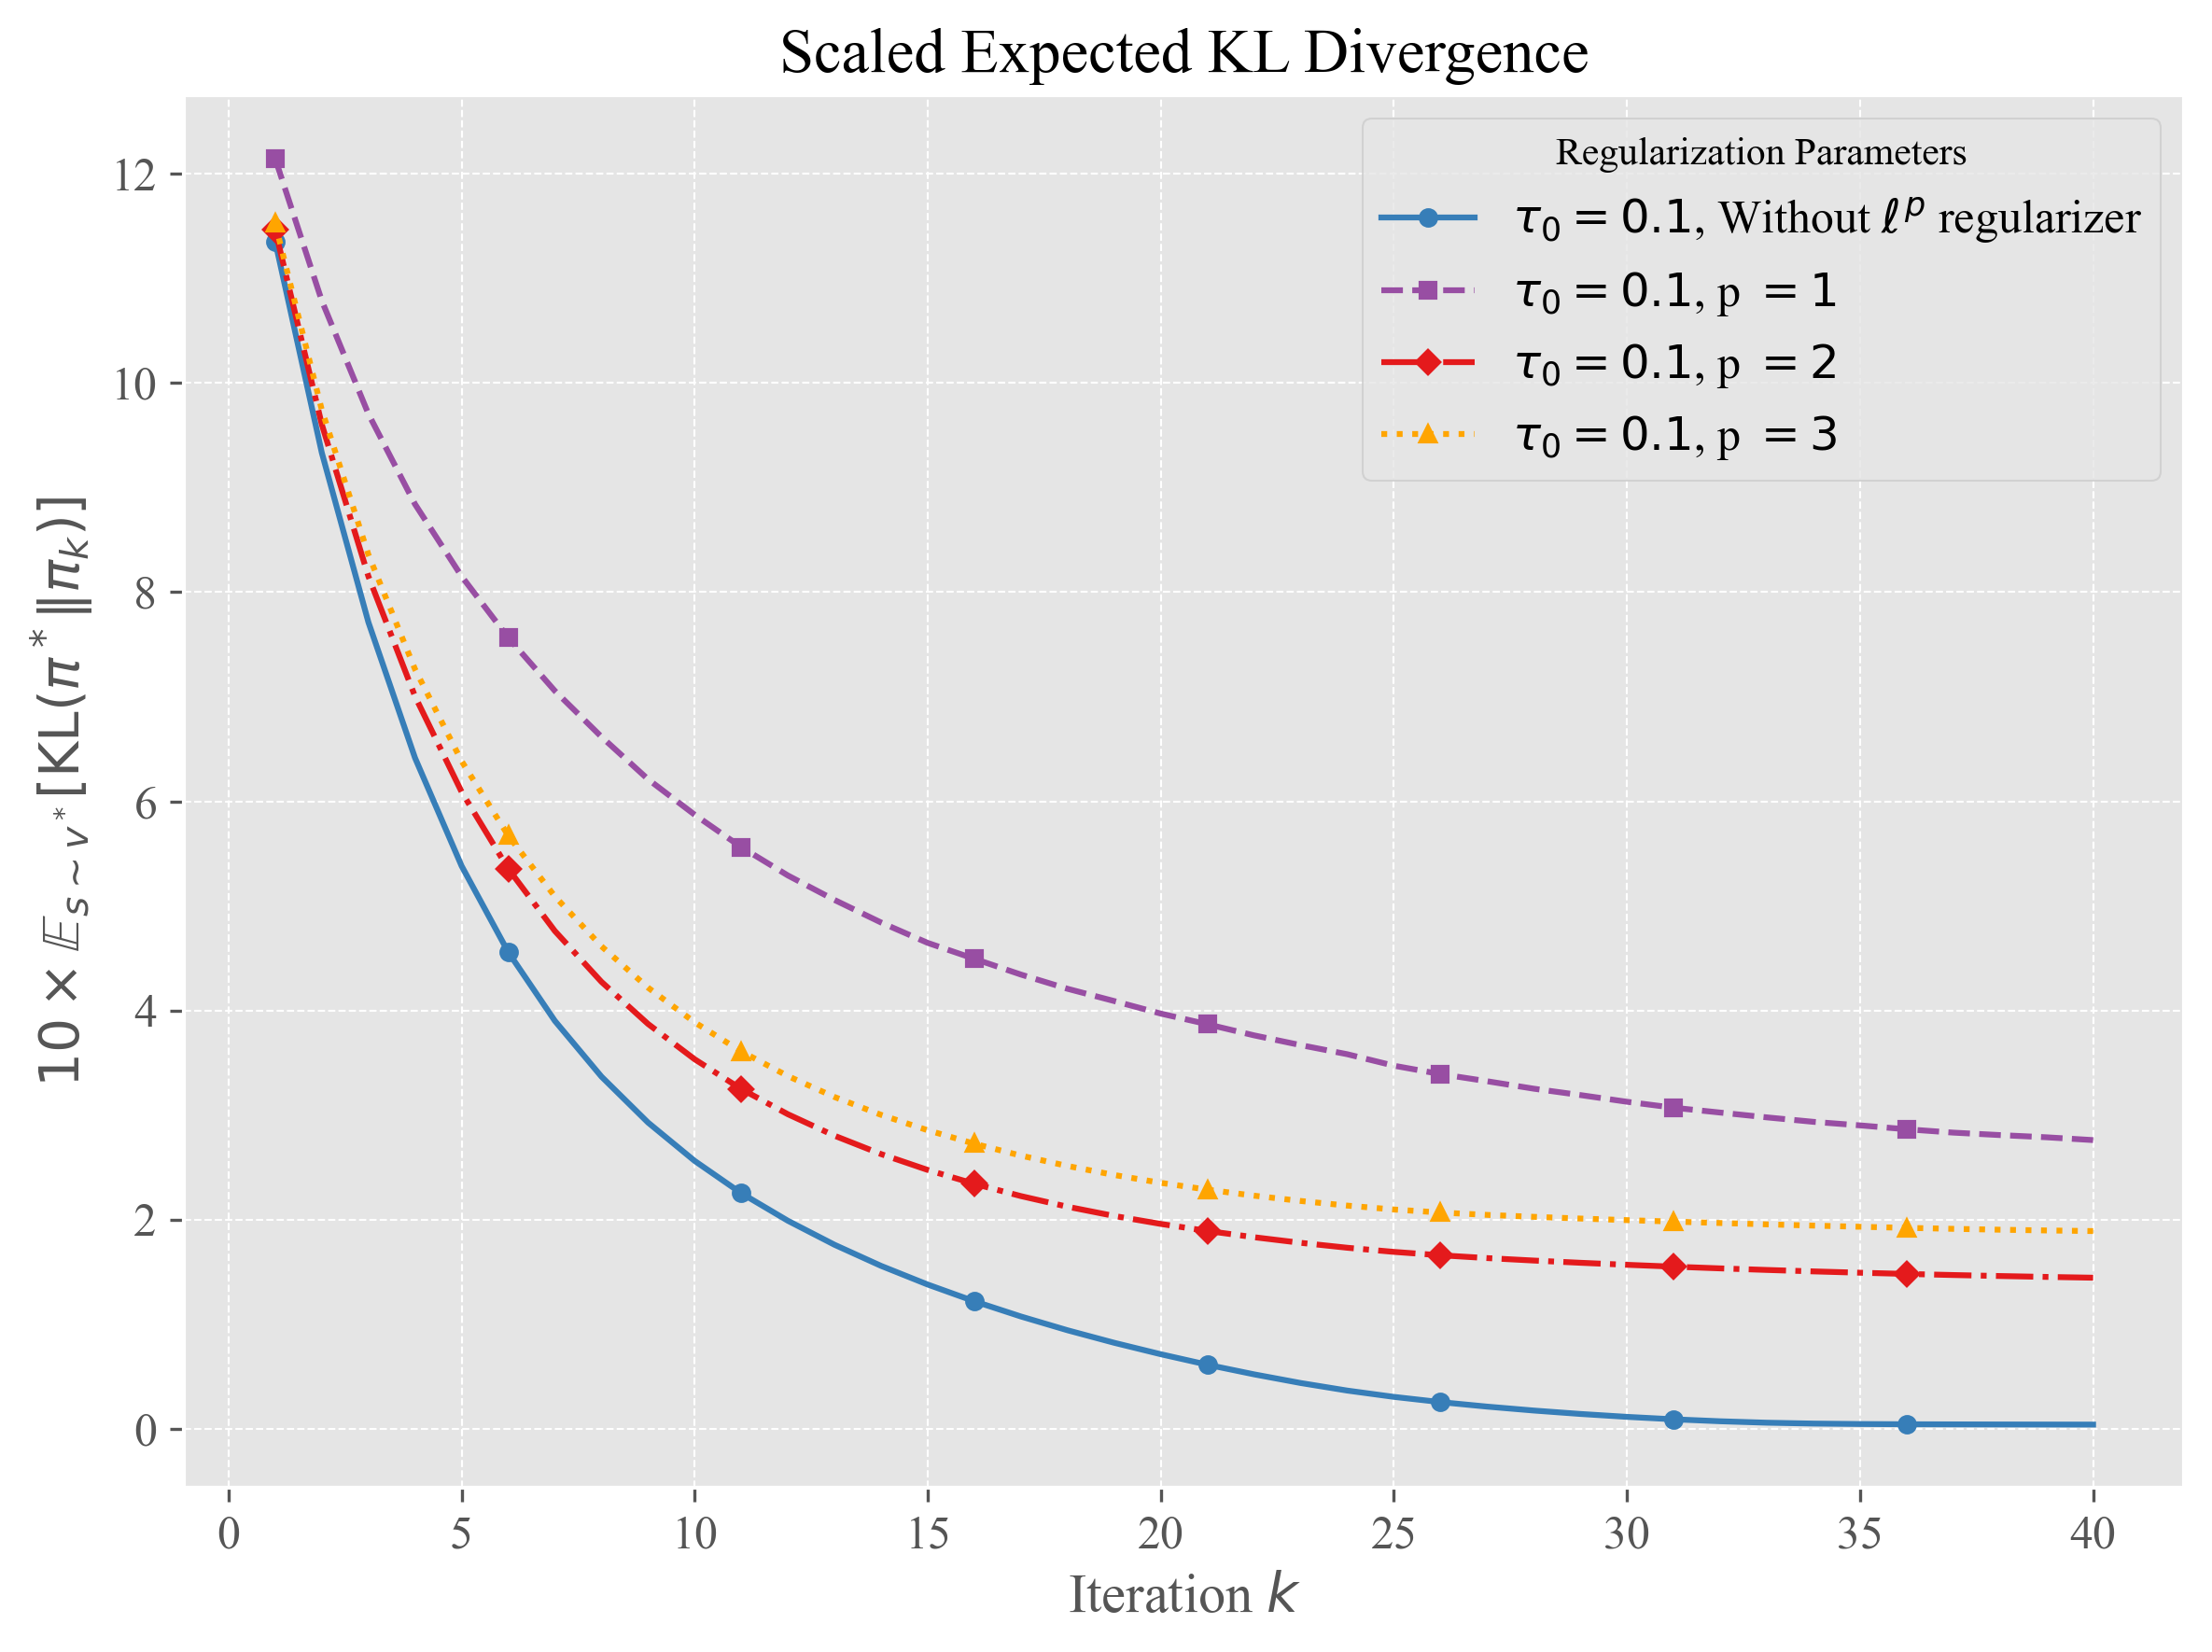

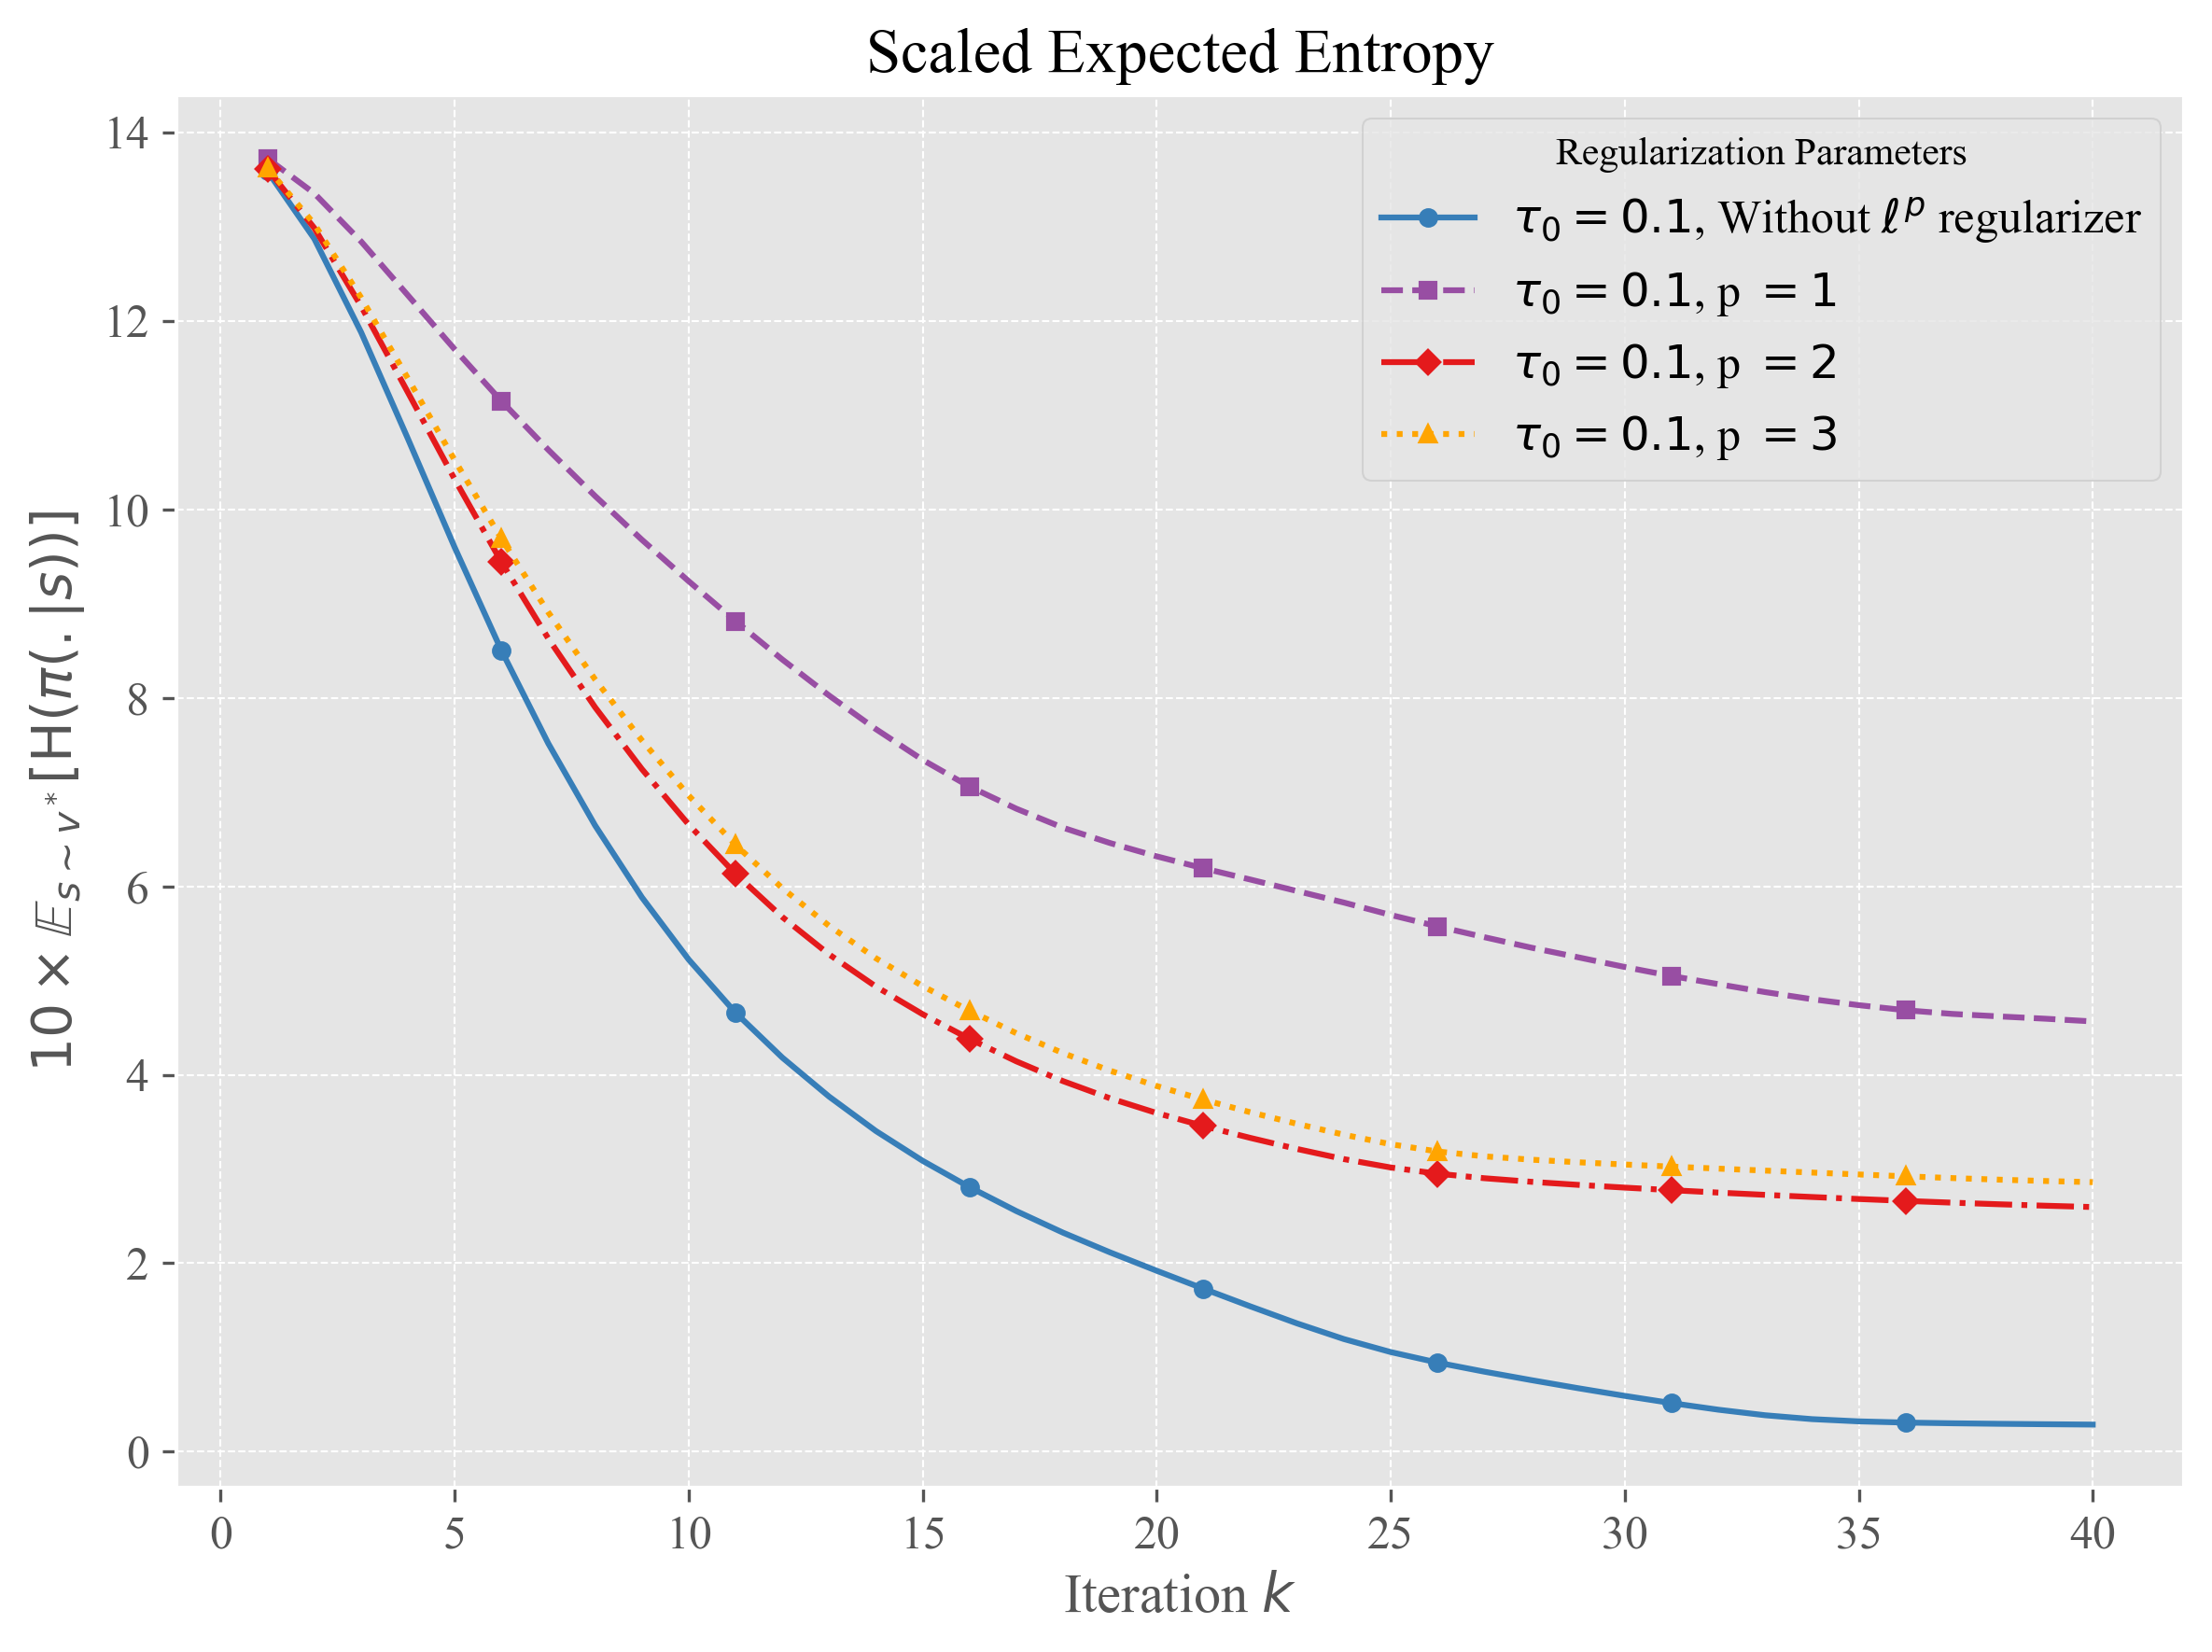

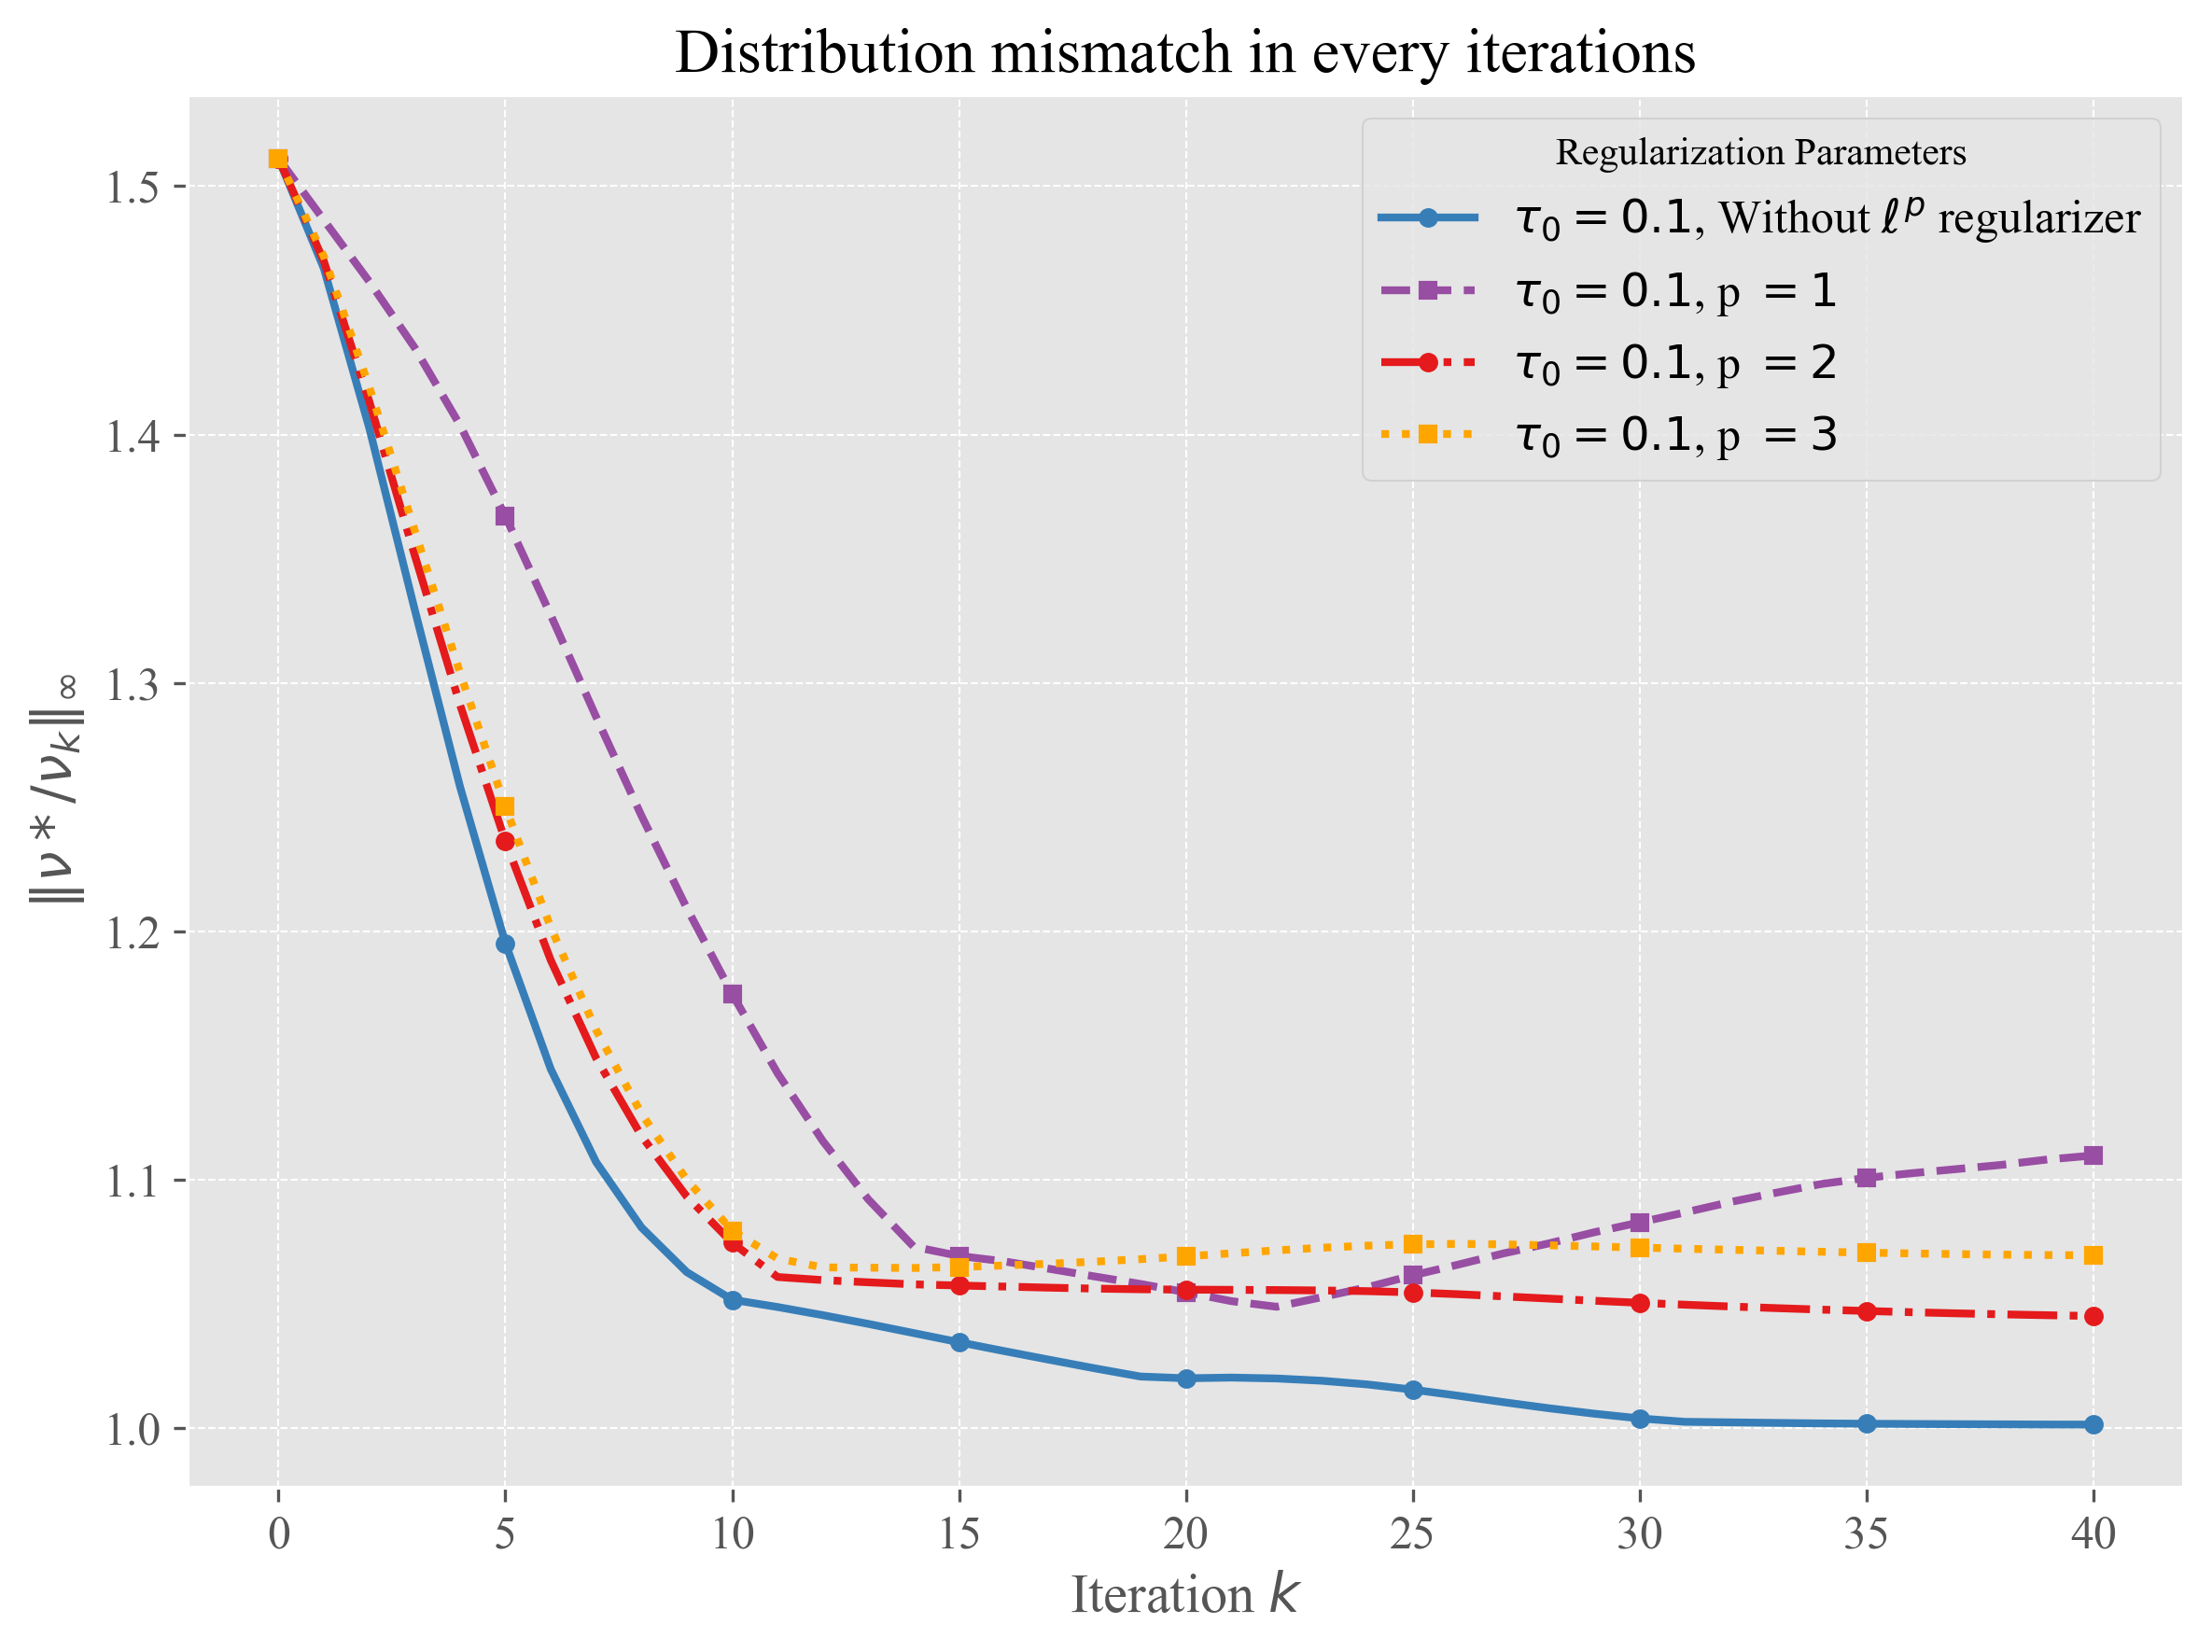

In [10]:
tau = 0.1
tau1 = 0.1
tau2 = 0.1
tau3 = 0.1

tau0 = tau # to store the initializaion
tau01 = tau1 # to store the initializaion
tau02 = tau2 # to store the initializaion
tau03 = tau3 # to store the initializaion

eta = (1-gamma)/(gamma*tau)
eta1 = (1-gamma)/(gamma*tau1)
eta2 = (1-gamma)/(gamma*tau2)
eta3 = (1-gamma)/(gamma*tau3)

modulus_lp = 0
modulus_lp_second = 1
modulus_lp_third = 2
modulus_lp_forth = 3

lp_coef=0
lp_coef1=0.1
lp_coef2=0.1
lp_coef3=0.1



for k in range(K):
    Q_pi_k = estimate_q_function_exact(pi_k, tau, modulus_lp, gamma, lp_coef).to(device)
    Q_pi_k1 = estimate_q_function_exact(pi_k1, tau1, modulus_lp_second, gamma, lp_coef1).to(device)
    Q_pi_k2= estimate_q_function_exact(pi_k2, tau2, modulus_lp_third, gamma, lp_coef2).to(device)
    Q_pi_k3 = estimate_q_function_exact(pi_k3, tau3, modulus_lp_forth, gamma, lp_coef3).to(device)
    
    record_q_exact.append(Q_pi_k)
    record_q1_exact1.append(Q_pi_k1)
    record_q2_exact2.append(Q_pi_k2)
    record_q3_exact3.append(Q_pi_k3)

    kl_term = 0
    kl_term1 = 0
    kl_term2 = 0
    kl_term3 = 0

    for i in range(num_states):
        pi_k_plus[i] = optimize_pi_k_s(i, pi_k, Q_pi_k, pi_0, eta, tau, modulus_lp, num_iters, stepsize, lp_coef)
        pi_k_plus1[i] = optimize_pi_k_s(i, pi_k1, Q_pi_k1, pi_0, eta1, tau1, modulus_lp_second, num_iters, stepsize, lp_coef1)
        pi_k_plus2[i] = optimize_pi_k_s(i, pi_k2, Q_pi_k2, pi_0, eta2, tau2, modulus_lp_third, num_iters, stepsize, lp_coef2)
        pi_k_plus3[i] = optimize_pi_k_s(i, pi_k3, Q_pi_k3, pi_0, eta3, tau3, modulus_lp_forth, num_iters, stepsize, lp_coef3)
        
        estim_value[i] = torch.dot(pi_k_plus[i], Q_pi_k[i]).item()
        estim_value1[i] = torch.dot(pi_k_plus1[i], Q_pi_k1[i]).item()
        estim_value2[i] = torch.dot(pi_k_plus2[i], Q_pi_k2[i]).item()
        estim_value3[i] = torch.dot(pi_k_plus3[i], Q_pi_k3[i]).item()
        
        kl_term += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus[i])
        kl_term1 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus1[i])   
        kl_term2 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus2[i])
        kl_term3 += opt_policy_ssd[i] * kl_divergence(optimal_policy[i], pi_k_plus3[i])   
        
    estim_value_ssd[k] = torch.dot(estim_value, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd1[k] = torch.dot(estim_value1, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd2[k] = torch.dot(estim_value2, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd
    estim_value_ssd3[k] = torch.dot(estim_value3, opt_policy_ssd).item() # expectation of value function V_pi_k(s) wrt s ~ opt_policy_ssd

    exp_entropy.append(10*expected_entropy(pi_k_plus, opt_policy_ssd).item())
    exp_entropy1.append(10*expected_entropy(pi_k_plus1, opt_policy_ssd).item())
    exp_entropy2.append(10*expected_entropy(pi_k_plus2, opt_policy_ssd).item())
    exp_entropy3.append(10*expected_entropy(pi_k_plus3, opt_policy_ssd).item())

    
    pi_k = pi_k_plus
    pi_k1 = pi_k_plus1
    pi_k2 = pi_k_plus2
    pi_k3 = pi_k_plus3

    record_p_exact.append(pi_k)
    record_p1_exact1.append(pi_k1)
    record_p2_exact2.append(pi_k2)
    record_p3_exact3.append(pi_k3)


    tau*=gamma
    eta = (1-gamma)/(gamma*tau)
    tau1*=gamma
    eta1 = (1-gamma)/(gamma*tau1)
    tau2*=gamma
    eta2 = (1-gamma)/(gamma*tau2)
    tau3*=gamma
    eta3 = (1-gamma)/(gamma*tau3)
    
    V_pi_k_s0 = torch.dot(pi_k[s0], Q_pi_k[s0]).item()
    V_pi_k_s01 = torch.dot(pi_k1[s0], Q_pi_k1[s0]).item()
    V_pi_k_s02 = torch.dot(pi_k2[s0], Q_pi_k2[s0]).item()
    V_pi_k_s03 = torch.dot(pi_k3[s0], Q_pi_k3[s0]).item()

    values.append(V_pi_k_s0)
    values1.append(V_pi_k_s01)
    values2.append(V_pi_k_s02)
    values3.append(V_pi_k_s03)
    
    KLterm.append((10*kl_term).item())
    KLterm1.append((10*kl_term1).item())
    KLterm2.append((10*kl_term2).item())
    KLterm3.append((10*kl_term3).item())

    diff.append(mismatch(pi_k))
    diff1.append(mismatch(pi_k1))
    diff2.append(mismatch(pi_k2))
    diff3.append(mismatch(pi_k3))
    
    print(f"Pi_{k}(.|s0), 1st = {pi_k[0]}")
    print(f"Pi_{k}(.|s0), 2nd= {pi_k1[0]}")
    print(f"Pi_{k}(.|s0), 3rd = {pi_k2[0]}")
    print(f"Pi_{k}(.|s0), 4th= {pi_k3[0]}")
    
    print(f'under steady state distribution at iteration {k}:')
    print('estm value, 1st:',estim_value_ssd[k].item(),'opt value:', opt_ssd)
    print('estm value, 2nd:',estim_value_ssd1[k].item(),'opt value:', opt_ssd)
    print('estm value, 3rd:',estim_value_ssd2[k].item(),'opt value:', opt_ssd)
    print('estm value, 4th:',estim_value_ssd3[k].item(),'opt value:', opt_ssd)
    print()
    
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 1st : {10*kl_term}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 2nd : {10*kl_term1}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 3rd : {10*kl_term2}')
    print(f'E[KL(pi*(s) || pi_{k}(s))] ~ssd, 4th : {10*kl_term3}')
    print()




expected_opt_gap = estim_value_ssd[0:K] - opt_ssd
expected_opt_gap1 = estim_value_ssd1[0:K] - opt_ssd
expected_opt_gap2 = estim_value_ssd2[0:K] - opt_ssd
expected_opt_gap3 = estim_value_ssd3[0:K] - opt_ssd


record_value_exact.append(expected_opt_gap)
record_value_exact1.append(expected_opt_gap1)
record_value_exact2.append(expected_opt_gap2)
record_value_exact3.append(expected_opt_gap3)

record_kl_exact.append(KLterm)
record_kl_exact1.append(KLterm1)
record_kl_exact2.append(KLterm2)
record_kl_exact3.append(KLterm3)

record_entr_exact.append(exp_entropy)
record_entr_exact1.append(exp_entropy1)
record_entr_exact2.append(exp_entropy2)
record_entr_exact3.append(exp_entropy3)

record_mism_exact.append(diff)
record_mism_exact1.append(diff1)
record_mism_exact2.append(diff2)
record_mism_exact3.append(diff3)


print('expected optimality gap after last iteration, 1st', expected_opt_gap[-1])
print('expected optimality gap after last iteration, 2nd', expected_opt_gap1[-1])
print('expected optimality gap after last iteration, 3rd', expected_opt_gap2[-1])
print('expected optimality gap after last iteration, 4th', expected_opt_gap3[-1])

plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), expected_opt_gap.tolist(), color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), expected_opt_gap1.tolist(), color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), expected_opt_gap2.tolist(), color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), expected_opt_gap3.tolist(), color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$\\mathbb{E}_{s \\sim v^*}[V^k] - \\mathbb{E}_{s \\sim v^*}[V^*]$', fontsize=14)
plt.title('Expected Optimality Gap', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_optimality_lp00000.png', dpi=300)



plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), KLterm, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), KLterm1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), KLterm2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), KLterm3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{KL}(\\pi^* \\| \\pi_k)]$', fontsize=14)
plt.title('Scaled Expected KL Divergence', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_lp00000.png', dpi=300)
plt.show()


plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(1, K+1), exp_entropy, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), exp_entropy1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), exp_entropy2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), exp_entropy3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=1.5, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{H}(\\pi(.|s))]$', fontsize=14)
plt.title('Scaled Expected Entropy', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_divergence_lp00000.png', dpi=300)
plt.show()




plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500']  # Blue, Purple, , Red, Orange
markers = ['o', 's', 'o', 's']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution
plt.plot(range(0, K+1), diff, color=colors[0], linestyle=linestyles[0],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(0, K+1), diff1, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(0, K+1), diff2, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(0, K+1), diff3, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")
plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel(r'$\|\nu*/\nu_k\|_\infty$', fontsize=14)
plt.title('Distribution mismatch in every iterations', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('expected_kl_lp00000.png', dpi=300)
plt.show()

In [ ]:
# Joint plots

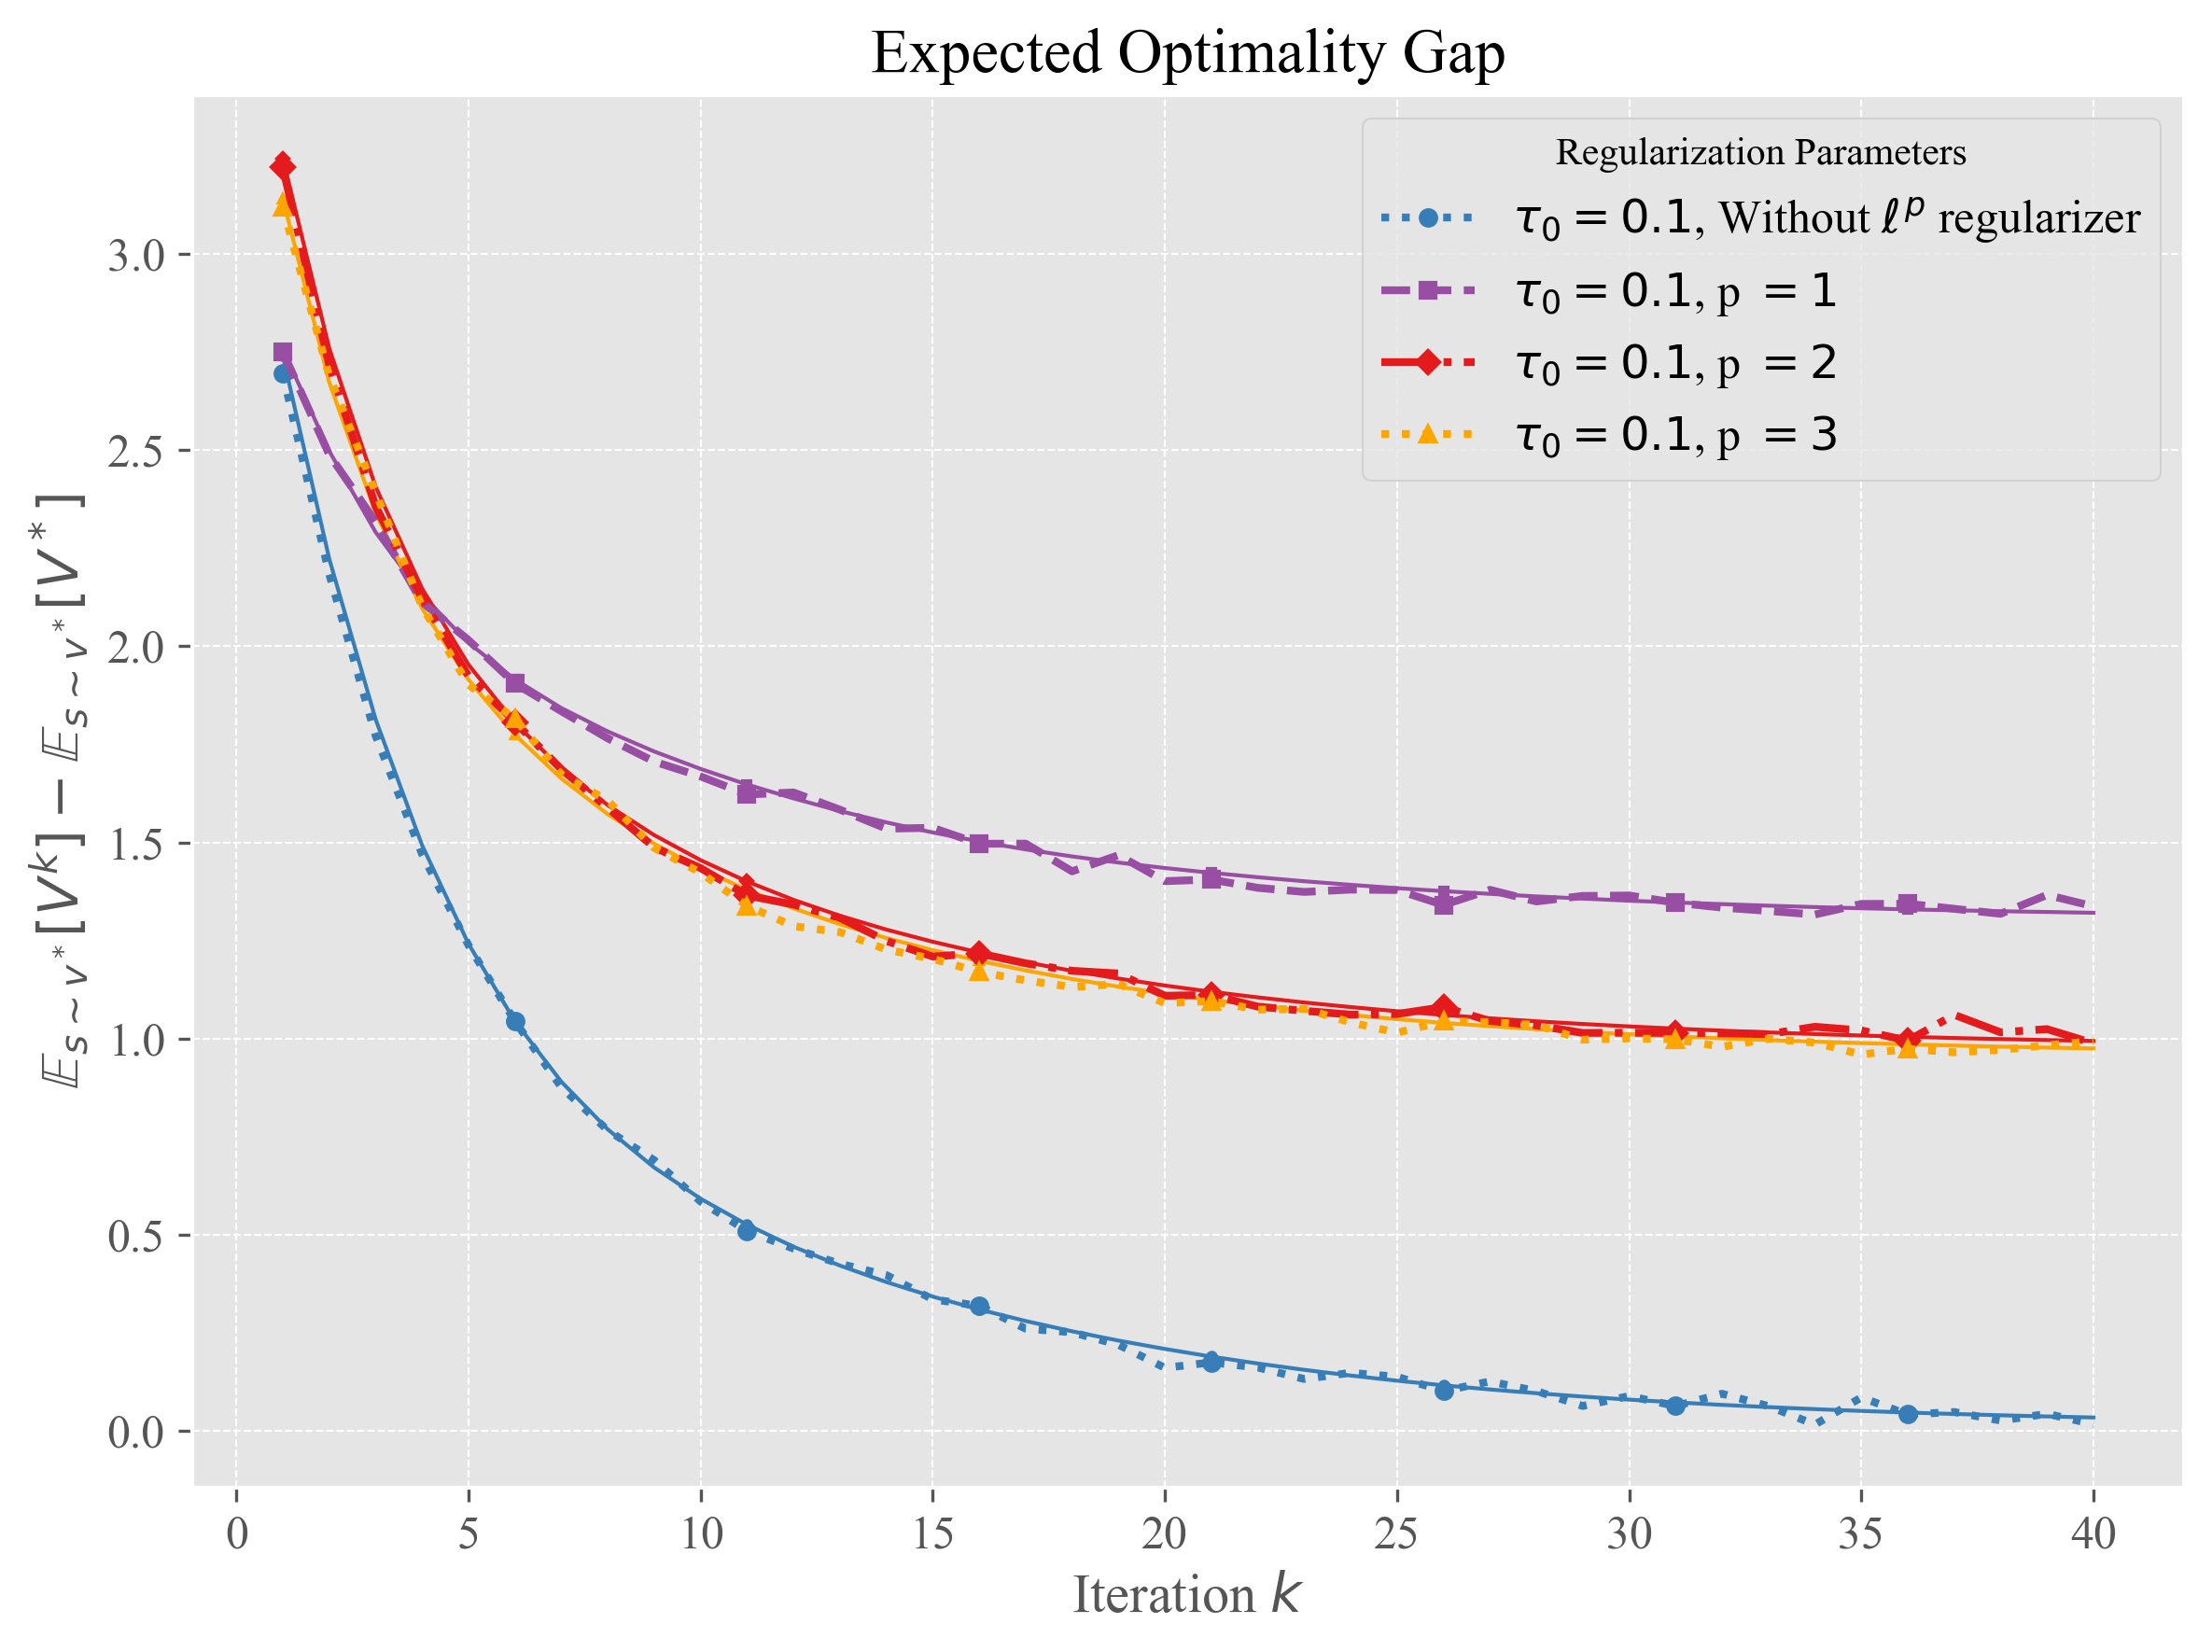

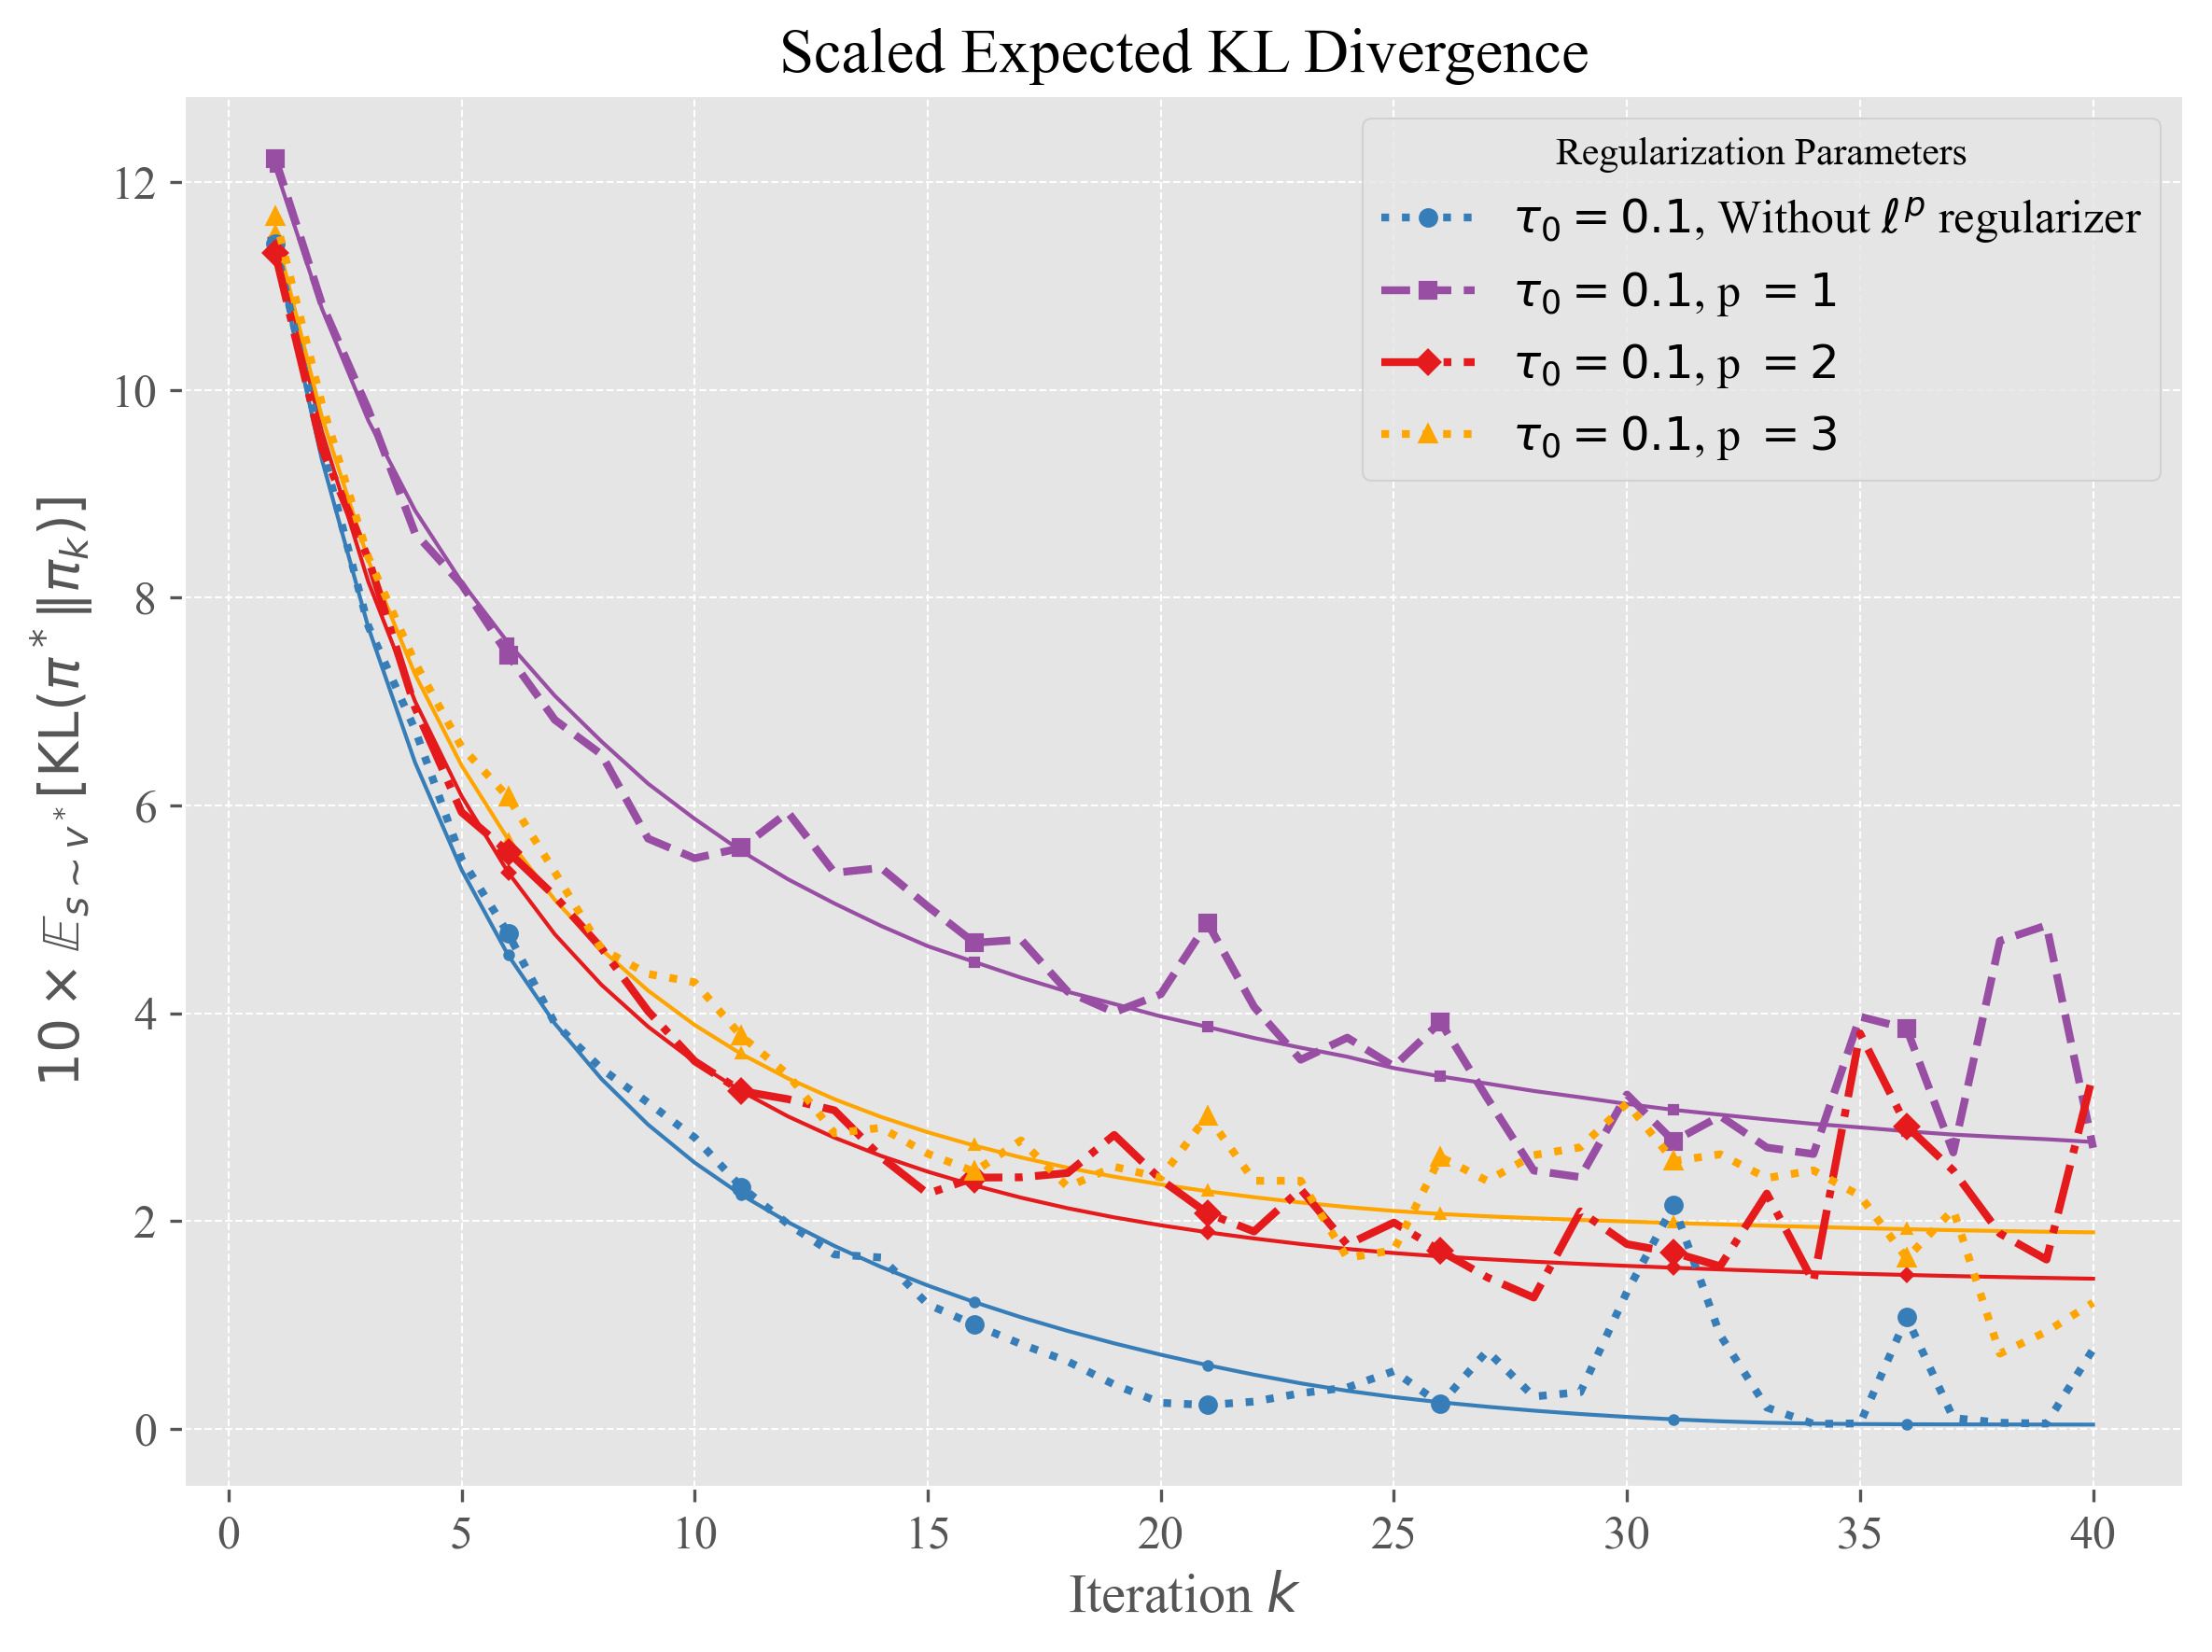

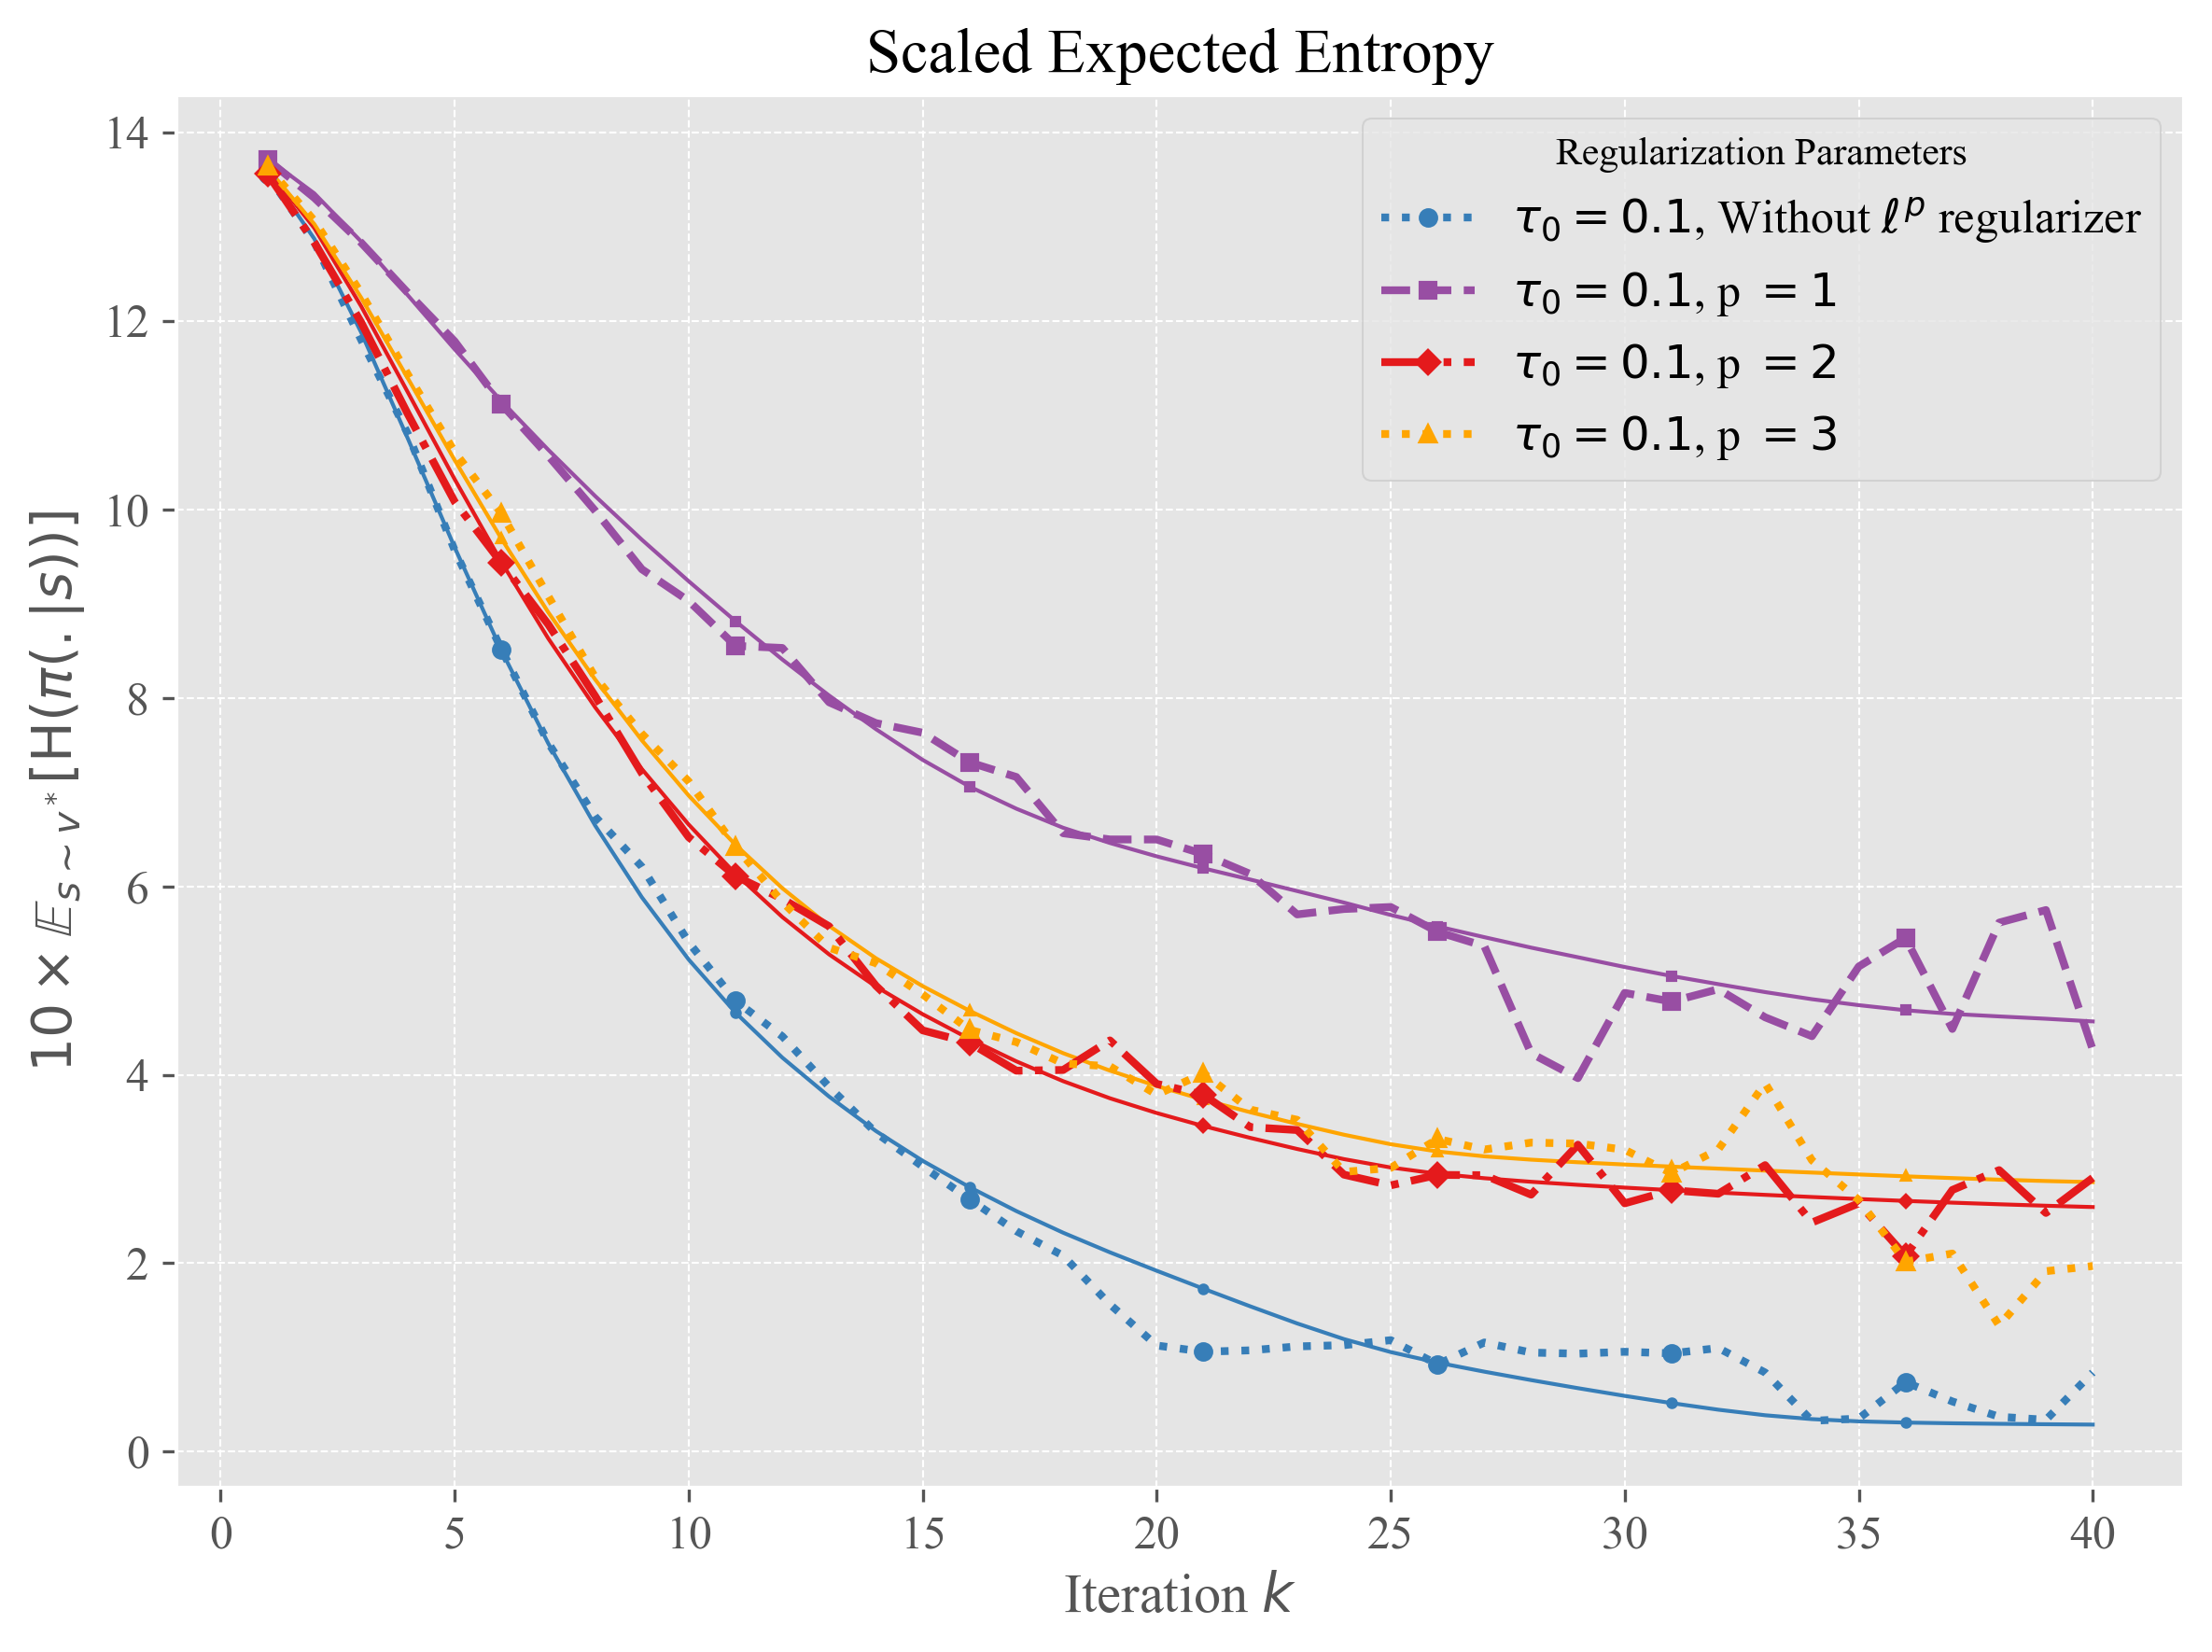

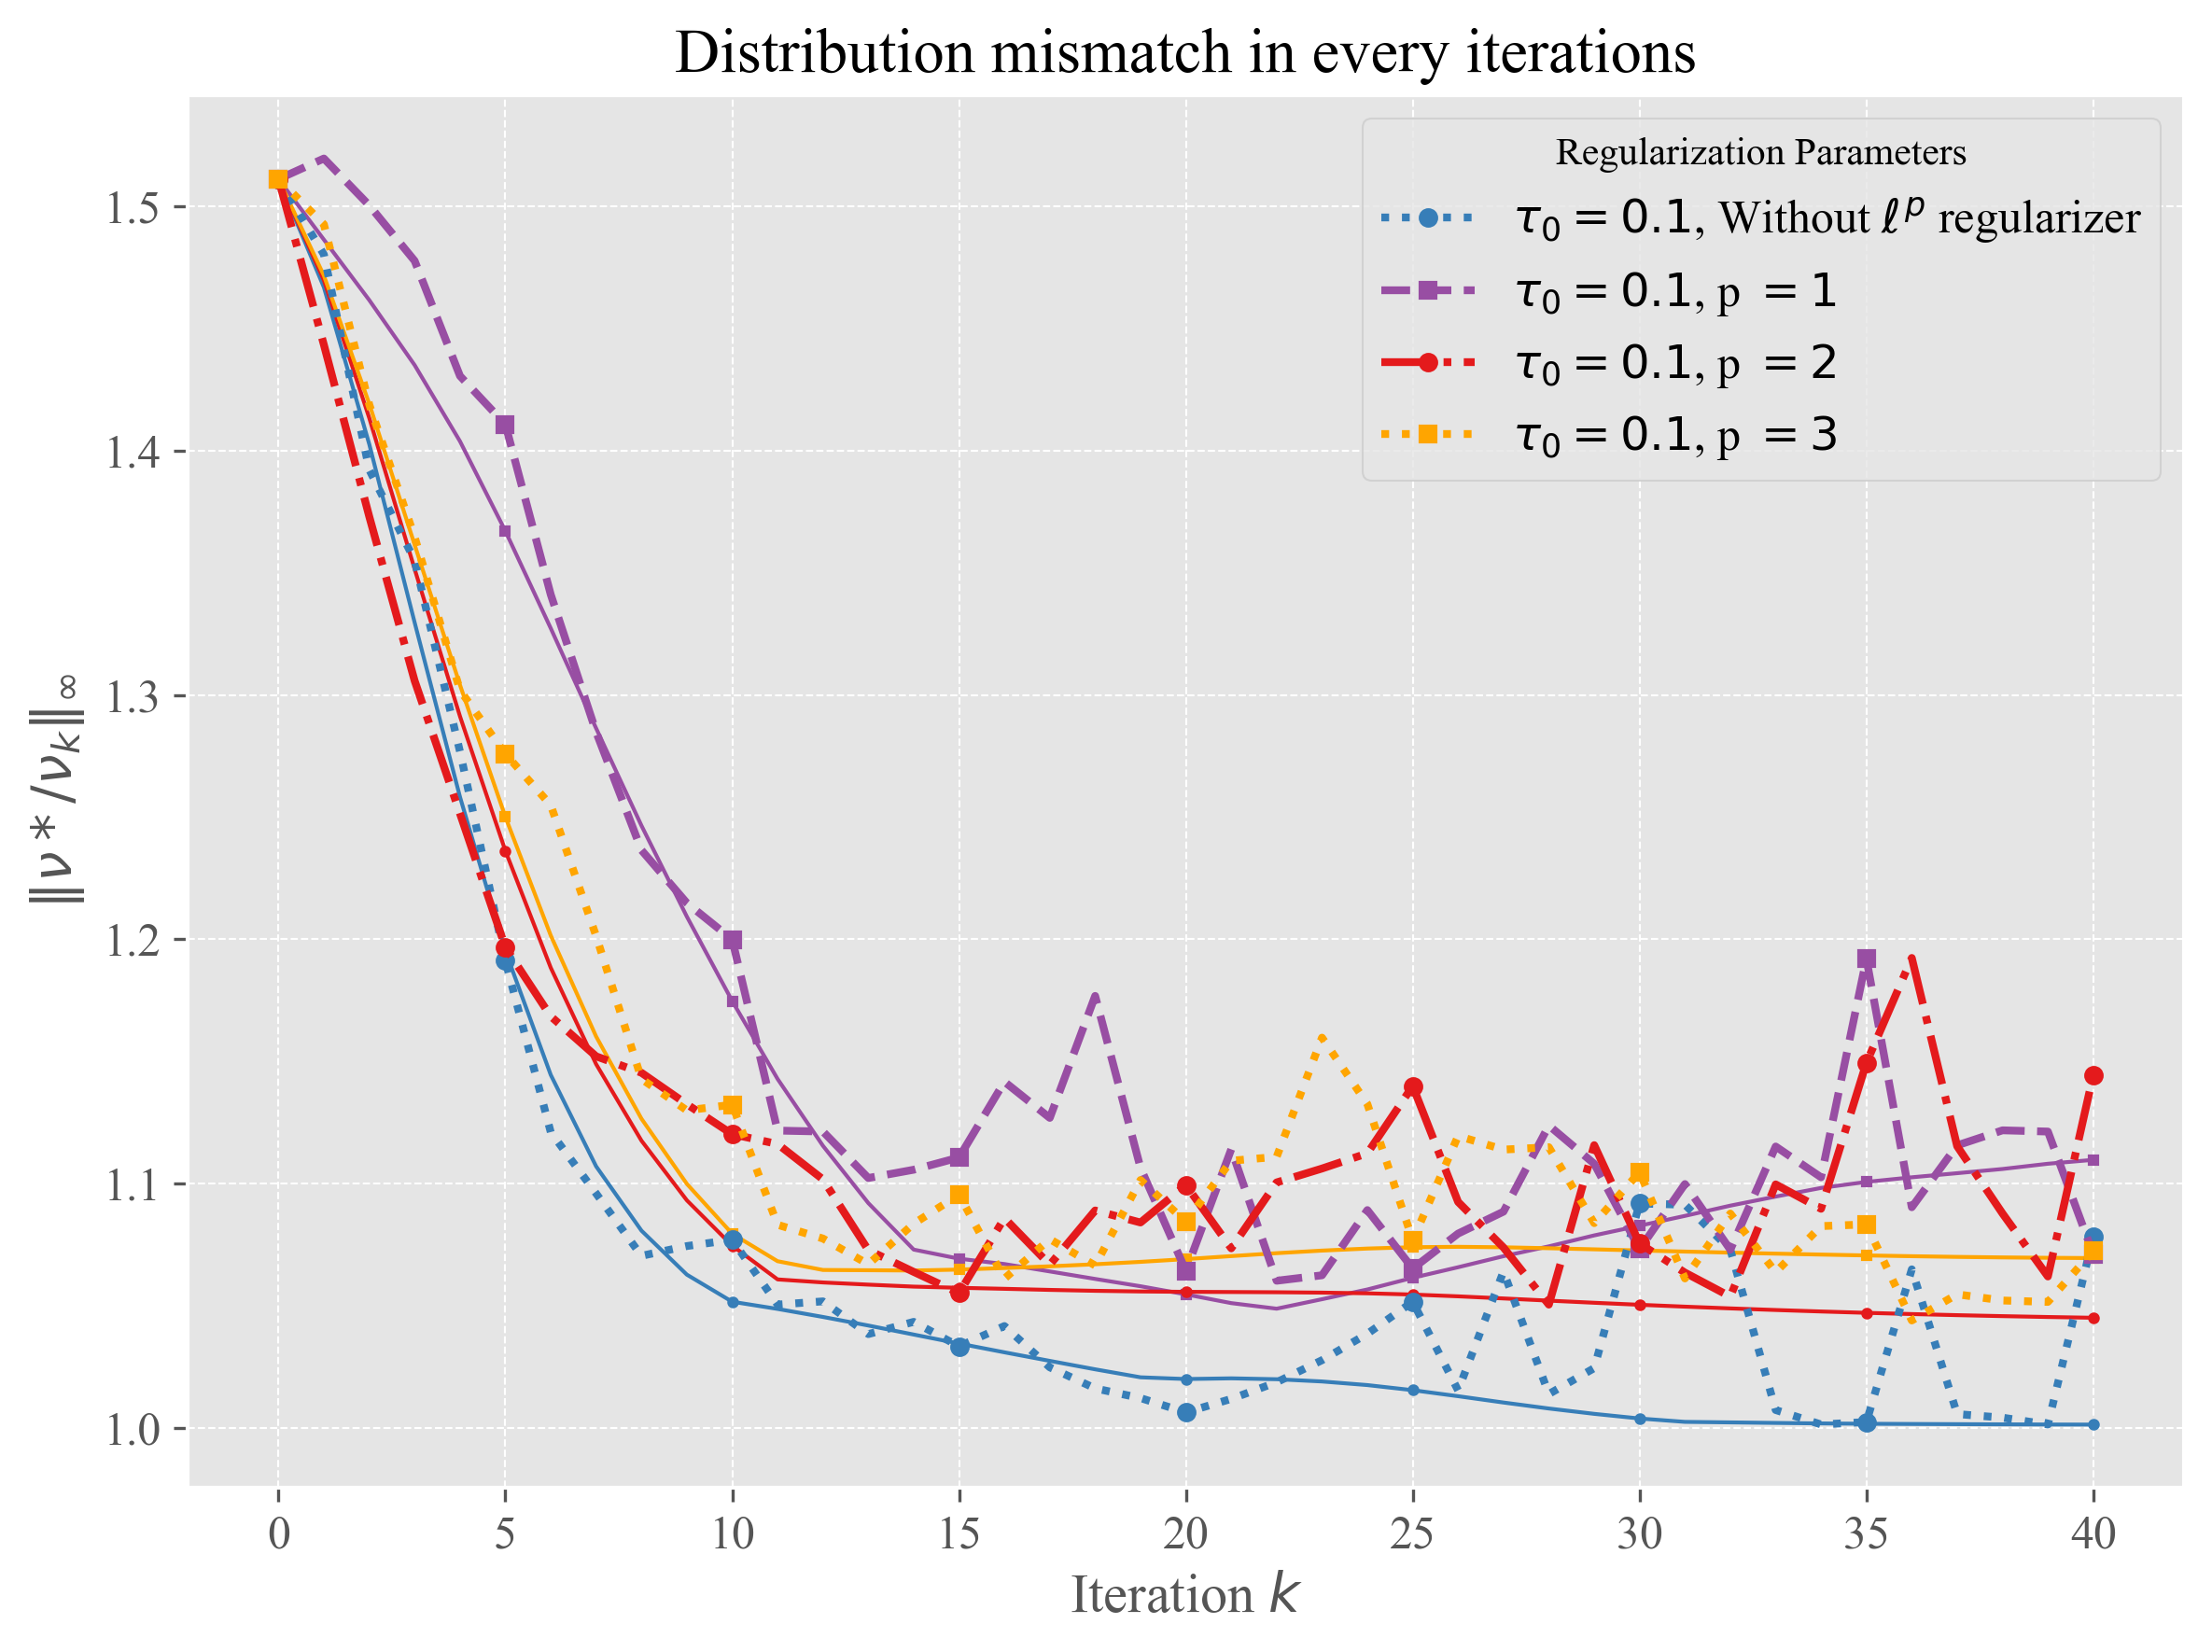

In [11]:
plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500', '#000000']  # Blue, Purple, , Red, Orange, black
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution

plt.plot(range(1, K+1), expected_opt_gap.tolist(), color=colors[0], marker=markers[0],
        markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), expected_opt_gap1.tolist(), color=colors[1], marker=markers[1],
        markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), expected_opt_gap2.tolist(), color=colors[2], marker=markers[2],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), expected_opt_gap3.tolist(), color=colors[3], marker=markers[3],
         markevery=5, linewidth=1, markersize=2)

plt.plot(range(1, K+1), expected_opt_gap0.tolist(), color=colors[0], linestyle=linestyles[3],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), expected_opt_gap01.tolist(), color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), expected_opt_gap02.tolist(), color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), expected_opt_gap03.tolist(), color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")

plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$\\mathbb{E}_{s \\sim v^*}[V^k] - \\mathbb{E}_{s \\sim v^*}[V^*]$', fontsize=14)
plt.title('Expected Optimality Gap', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('0000comp_expected_optimality_gap_plot_stoc_v.png', dpi=300)
plt.show()




plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500', '#000000']  # Blue, Purple, , Red, Orange, black
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution

plt.plot(range(1, K+1), KLterm, color=colors[0], marker=markers[0],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), KLterm1, color=colors[1], marker=markers[1],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), KLterm2, color=colors[2], marker=markers[2],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), KLterm3, color=colors[3], marker=markers[3],
         markevery=5, linewidth=1, markersize=2)

plt.plot(range(1, K+1), KLterm0, color=colors[0], linestyle=linestyles[3],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), KLterm01, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), KLterm02, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), KLterm03, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")


plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{KL}(\\pi^* \\| \\pi_k)]$', fontsize=14)
plt.title('Scaled Expected KL Divergence', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('0000comp_expected_kl_divergence_plot_stoc_kl.png', dpi=300)
plt.show()





plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500', '#000000']  # Blue, Purple, , Red, Orange, black
markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution

plt.plot(range(1, K+1), exp_entropy, color=colors[0], marker=markers[0],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), exp_entropy1, color=colors[1],marker=markers[1],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), exp_entropy2, color=colors[2],marker=markers[2],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(1, K+1), exp_entropy3, color=colors[3],marker=markers[3],
         markevery=5, linewidth=1, markersize=2)

plt.plot(range(1, K+1), exp_entropy0, color=colors[0], linestyle=linestyles[3],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(1, K+1), exp_entropy01, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(1, K+1), exp_entropy02, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(1, K+1), exp_entropy03, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")

plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel('$10 \\times \\mathbb{E}_{s \\sim v^*} [\\mathrm{H}(\\pi(.|s))]$', fontsize=14)
plt.title('Scaled Expected Entropy', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('0000comp_expected_kl_divergence_plot_stoc_entr.png', dpi=300)
plt.show()




plt.style.use('ggplot')  # Change to 'fivethirtyeight' or another style if preferred
mpl.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = ['#377eb8', '#984ea3', '#e41a1c', '#FFA500', '#000000']  # Blue, Purple, , Red, Orange, black
markers = ['o', 's', 'o', 's']  # Circle, Square, Diamond, Triangle Up
linestyles = ['-', '--', '-.', ':']  # Solid, Dashed, Dash-dot, Dotted
plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and resolution

plt.plot(range(0, K+1), diff, color=colors[0], marker=markers[0],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(0, K+1), diff1, color=colors[1], marker=markers[1],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(0, K+1), diff2, color=colors[2], marker=markers[2],
         markevery=5, linewidth=1, markersize=2)
plt.plot(range(0, K+1), diff3, color=colors[3], marker=markers[3],
         markevery=5, linewidth=1, markersize=2)

plt.plot(range(0, K+1), diff0, color=colors[0], linestyle=linestyles[3],
         marker=markers[0], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau0}$, Without $\\ell^p$ regularizer")
plt.plot(range(0, K+1), diff01, color=colors[1], linestyle=linestyles[1],
         marker=markers[1], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau01}$, p $= {modulus_lp_second}$")
plt.plot(range(0, K+1), diff02, color=colors[2], linestyle=linestyles[2],
         marker=markers[2], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau02}$, p $= {modulus_lp_third}$")
plt.plot(range(0, K+1), diff03, color=colors[3], linestyle=linestyles[3],
         marker=markers[3], markevery=5, linewidth=2, markersize=4, label=f"$\\tau_0 = {tau03}$, p $= {modulus_lp_forth}$")

plt.xlabel('Iteration $k$', fontsize=14)
plt.ylabel(r'$\|\nu*/\nu_k\|_\infty$', fontsize=14)
plt.title('Distribution mismatch in every iterations', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Regularization Parameters', loc='best', frameon=True)
plt.tight_layout()
plt.savefig('0000comp_expected_kl_divergence_plot_apmdnpg_entr.png', dpi=300)
plt.show()

In [ ]:
# code to save data 

In [27]:
# data_to_save = {
#     'record_value_stoch': record_value_stoch,
#     'record_value_stoch1': record_value_stoch1,
#     'record_value_stoch2': record_value_stoch2,
#     'record_value_stoch3': record_value_stoch3,

#     'record_kl_stoch': record_kl_stoch,
#     'record_kl_stoch1': record_kl_stoch1,
#     'record_kl_stoch2': record_kl_stoch2,
#     'record_kl_stoch3': record_kl_stoch3,

#     'record_entr_stoch': record_entr_stoch,
#     'record_entr_stoch1': record_entr_stoch1,
#     'record_entr_stoch2': record_entr_stoch2,
#     'record_entr_stoch3': record_entr_stoch3,

#     'record_mism_stoch': record_mism_stoch,
#     'record_mism_stoch1': record_mism_stoch1,
#     'record_mism_stoch2': record_mism_stoch2,
#     'record_mism_stoch3': record_mism_stoch3,

#     'record_q_stoch': record_q_stoch,
#     'record_q1_stoch': record_q1_stoch,
#     'record_q2_stoch': record_q2_stoch,
#     'record_q3_stoch': record_q3_stoch,

#     'record_p_stoch': record_p_stoch,
#     'record_p1_stoch': record_p1_stoch,
#     'record_p2_stoch': record_p2_stoch,
#     'record_p3_stoch': record_p3_stoch,

#     'expected_opt_gap0': expected_opt_gap0,
#     'expected_opt_gap01': expected_opt_gap01,
#     'expected_opt_gap02': expected_opt_gap02,
#     'expected_opt_gap03': expected_opt_gap03,

#     'expected_opt_gap': expected_opt_gap,
#     'expected_opt_gap1': expected_opt_gap1,
#     'expected_opt_gap2': expected_opt_gap2,
#     'expected_opt_gap3': expected_opt_gap3,

#     'opt_ssd': opt_ssd,

#     'record_value_exact': record_value_exact,
#     'record_value_exact1': record_value_exact1,
#     'record_value_exact2': record_value_exact2,
#     'record_value_exact3': record_value_exact3,

#     'record_kl_exact': record_kl_exact,
#     'record_kl_exact1': record_kl_exact1,
#     'record_kl_exact2': record_kl_exact2,
#     'record_kl_exact3': record_kl_exact3,

#     'record_entr_exact': record_entr_exact,
#     'record_entr_exact1': record_entr_exact1,
#     'record_entr_exact2': record_entr_exact2,
#     'record_entr_exact3': record_entr_exact3,

#     'record_mism_exact': record_mism_exact,
#     'record_mism_exact1': record_mism_exact1,
#     'record_mism_exact2': record_mism_exact2,
#     'record_mism_exact3': record_mism_exact3,

#     'record_q_exact': record_q_exact,
#     'record_q1_exact': record_q1_exact1,
#     'record_q2_exact': record_q2_exact2,
#     'record_q3_exact': record_q3_exact3,

#     'record_p_exact': record_p_exact,
#     'record_p1_exact': record_p1_exact1,
#     'record_p2_exact': record_p2_exact2,
#     'record_p3_exact': record_p3_exact3,
# }
# save_path = "C:/Users/rzoln/Desktop/figs/stoclpkl/all_tensor_lists.pth" 
# torch.save(data_to_save, save_path)
# print(f"All tensor lists have been successfully saved to {save_path}")

All tensor lists have been successfully saved to C:/Users/rzoln/Desktop/figs/stoclpkl/all_tensor_lists.pth


In [ ]:
# code to load data

In [ ]:
# load_path = "C:/Users/rzoln/Desktop/figs/stoclpkl/all_tensor_lists.pth"  

# loaded_data = torch.load(load_path)

# print(f"All tensor lists have been successfully loaded from {load_path}")

# record_value_stoch = loaded_data['record_value_stoch']
# record_value_stoch1 = loaded_data['record_value_stoch1']
# record_value_stoch2 = loaded_data['record_value_stoch2']
# record_value_stoch3 = loaded_data['record_value_stoch3']

# record_kl_stoch = loaded_data['record_kl_stoch']
# record_kl_stoch1 = loaded_data['record_kl_stoch1']
# record_kl_stoch2 = loaded_data['record_kl_stoch2']
# record_kl_stoch3 = loaded_data['record_kl_stoch3']

# record_entr_stoch = loaded_data['record_entr_stoch']
# record_entr_stoch1 = loaded_data['record_entr_stoch1']
# record_entr_stoch2 = loaded_data['record_entr_stoch2']
# record_entr_stoch3 = loaded_data['record_entr_stoch3']

# record_mism_stoch = loaded_data['record_mism_stoch']
# record_mism_stoch1 = loaded_data['record_mism_stoch1']
# record_mism_stoch2 = loaded_data['record_mism_stoch2']
# record_mism_stoch3 = loaded_data['record_mism_stoch3']

# record_q_stoch = loaded_data['record_q_stoch']
# record_q1_stoch = loaded_data['record_q1_stoch']
# record_q2_stoch = loaded_data['record_q2_stoch']
# record_q3_stoch = loaded_data['record_q3_stoch']

# record_p_stoch = loaded_data['record_p_stoch']
# record_p1_stoch = loaded_data['record_p1_stoch']
# record_p2_stoch = loaded_data['record_p2_stoch']
# record_p3_stoch = loaded_data['record_p3_stoch']

# expected_opt_gap0 = loaded_data['expected_opt_gap0']
# expected_opt_gap01 = loaded_data['expected_opt_gap01']
# expected_opt_gap02 = loaded_data['expected_opt_gap02']
# expected_opt_gap03 = loaded_data['expected_opt_gap03']

# expected_opt_gap = loaded_data['expected_opt_gap']
# expected_opt_gap1 = loaded_data['expected_opt_gap1']
# expected_opt_gap2 = loaded_data['expected_opt_gap2']
# expected_opt_gap3 = loaded_data['expected_opt_gap3']

# opt_ssd = loaded_data['opt_ssd']

# record_value_exact = loaded_data['record_value_exact']
# record_value_exact1 = loaded_data['record_value_exact1']
# record_value_exact2 = loaded_data['record_value_exact2']
# record_value_exact3 = loaded_data['record_value_exact3']

# record_kl_exact = loaded_data['record_kl_exact']
# record_kl_exact1 = loaded_data['record_kl_exact1']
# record_kl_exact2 = loaded_data['record_kl_exact2']
# record_kl_exact3 = loaded_data['record_kl_exact3']

# record_entr_exact = loaded_data['record_entr_exact']
# record_entr_exact1 = loaded_data['record_entr_exact1']
# record_entr_exact2 = loaded_data['record_entr_exact2']
# record_entr_exact3 = loaded_data['record_entr_exact3']

# record_mism_exact = loaded_data['record_mism_exact']
# record_mism_exact1 = loaded_data['record_mism_exact1']
# record_mism_exact2 = loaded_data['record_mism_exact2']
# record_mism_exact3 = loaded_data['record_mism_exact3']

# record_q_exact = loaded_data['record_q_exact']
# record_q1_exact = loaded_data['record_q1_exact1']
# record_q2_exact = loaded_data['record_q2_exact2']
# record_q3_exact = loaded_data['record_q3_exact3']

# record_p_exact = loaded_data['record_p_exact']
# record_p1_exact = loaded_data['record_p1_exact1']
# record_p2_exact = loaded_data['record_p2_exact2']
# record_p3_exact = loaded_data['record_p3_exact3']

# print("All lists have been assigned to variables.")


In [ ]:
# Tables calculations in chapter 6 :Contrasts in stochastic and deterministic Q-function estimation configurations

In [105]:
def absolute_difference(list1, list2):
    if type(list1[0])== list:
        l1=list1[0]
    if type(list2[0])== list:
        l2=list2[0]
    if type(list1[0])== torch.Tensor:
        l1=list1[0].tolist()
    if type(list2[0])== torch.Tensor:
        l2=list2[0].tolist()

    return [abs(a - b) for a, b in zip(l1, l2)]

def max_and_mean(lst):

    max_value = max(lst)
    mean_value = sum(lst) / len(lst)
    return max_value, mean_value
    
def print_with_name(variable_name, value):
    print(f"{variable_name} = {value}")

In [107]:
difference_value0= absolute_difference(record_value_stoch, record_value_exact)
difference_KL0= absolute_difference(record_kl_stoch, record_kl_exact)
difference_mismatch0= absolute_difference(record_mism_stoch, record_mism_exact)
difference_entrop0= absolute_difference(record_entr_stoch, record_entr_exact)

difference_value1= absolute_difference(record_value_stoch1, record_value_exact1)
difference_KL1= absolute_difference(record_kl_stoch1, record_kl_exact1)
difference_mismatch1= absolute_difference(record_mism_stoch1, record_mism_exact1)
difference_entrop1= absolute_difference(record_entr_stoch1, record_entr_exact1)

difference_value2= absolute_difference(record_value_stoch2, record_value_exact2)
difference_KL2= absolute_difference(record_kl_stoch2, record_kl_exact2)
difference_mismatch2= absolute_difference(record_mism_stoch2, record_mism_exact2)
difference_entrop2= absolute_difference(record_entr_stoch2, record_entr_exact2)

difference_value3= absolute_difference(record_value_stoch3, record_value_exact3)
difference_KL3= absolute_difference(record_kl_stoch3, record_kl_exact3)
difference_mismatch3= absolute_difference(record_mism_stoch3, record_mism_exact3)
difference_entrop3= absolute_difference(record_entr_stoch3, record_entr_exact3)


max_KL0, mean_KL0= max_and_mean(difference_KL0)
max_value0, mean_value0= max_and_mean(difference_value0)
max_mismatch0, mean_mismatch0= max_and_mean(difference_mismatch0)
max_entropy0, mean_entropy0= max_and_mean(difference_entrop0)

max_KL1, mean_KL1= max_and_mean(difference_KL1)
max_value1, mean_value1= max_and_mean(difference_value1)
max_mismatch1, mean_mismatch1= max_and_mean(difference_mismatch1)
max_entropy1, mean_entropy1= max_and_mean(difference_entrop1)

max_KL2, mean_KL2= max_and_mean(difference_KL2)
max_value2, mean_value2= max_and_mean(difference_value2)
max_mismatch2, mean_mismatch2= max_and_mean(difference_mismatch2)
max_entropy2, mean_entropy2= max_and_mean(difference_entrop2)

max_KL3, mean_KL3= max_and_mean(difference_KL3)
max_value3, mean_value3= max_and_mean(difference_value3)
max_mismatch3, mean_mismatch3= max_and_mean(difference_mismatch3)
max_entropy3, mean_entropy3= max_and_mean(difference_entrop3)

In [109]:


variables = {
    "max_KL0": max_KL0, "mean_KL0": mean_KL0,
    "max_value0": max_value0, "mean_value0": mean_value0,
    "max_mismatch0": max_mismatch0, "mean_mismatch0": mean_mismatch0,
    "max_entropy0": max_entropy0, "mean_entropy0": mean_entropy0,

    "max_KL1": max_KL1, "mean_KL1": mean_KL1,
    "max_value1": max_value1, "mean_value1": mean_value1,
    "max_mismatch1": max_mismatch1, "mean_mismatch1": mean_mismatch1,
    "max_entropy1": max_entropy1, "mean_entropy1": mean_entropy1,

    "max_KL2": max_KL2, "mean_KL2": mean_KL2,
    "max_value2": max_value2, "mean_value2": mean_value2,
    "max_mismatch2": max_mismatch2, "mean_mismatch2": mean_mismatch2,
    "max_entropy2": max_entropy2, "mean_entropy2": mean_entropy2,

    "max_KL3": max_KL3, "mean_KL3": mean_KL3,
    "max_value3": max_value3, "mean_value3": mean_value3,
    "max_mismatch3": max_mismatch3, "mean_mismatch3": mean_mismatch3,
    "max_entropy3": max_entropy3, "mean_entropy3": mean_entropy3,
}

for name, value in variables.items():
    print_with_name(name, round(value,3))


max_KL0 = 2.062
mean_KL0 = 0.286
max_value0 = 0.048
mean_value0 = 0.016
max_mismatch0 = 0.089
mean_mismatch0 = 0.019
max_entropy0 = 0.793
mean_entropy0 = 0.234
max_KL1 = 2.059
mean_KL1 = 0.391
max_value1 = 0.043
mean_value1 = 0.016
max_mismatch1 = 0.116
mean_mismatch1 = 0.028
max_entropy1 = 1.283
mean_entropy1 = 0.271
max_KL2 = 2.315
mean_KL2 = 0.377
max_value2 = 0.059
mean_value2 = 0.018
max_mismatch2 = 0.146
mean_mismatch2 = 0.039
max_entropy2 = 0.614
mean_entropy2 = 0.177
max_KL3 = 1.18
mean_KL3 = 0.366
max_value3 = 0.053
mean_value3 = 0.018
max_mismatch3 = 0.087
mean_mismatch3 = 0.023
max_entropy3 = 1.548
mean_entropy3 = 0.261
